In [ ]:
! pip install ipywidgets matplotlib

In [1]:
import torch
from ipywidgets import interact
import matplotlib.pyplot as plt

# This notebook tries to demonstrate how ReLU can estimate any continuous function.  
# Inspired by 'Practical Deep Learning' course designed by 'fast.ai'

In [2]:
def quad_funtion(a,b,c,x):
    return (a*x**2) + (b*x) + c

The function 'get_series_values' is designed to generate a series of values. Here, I am utilizing it to obtain default x values, while ensuring that the generated values remain consistent by setting a noise threshold.
'linspace' is a function creates an array of evenly spaced values over a specified interval. The interval is defined by a start value, an end value, and the number of elements to generate within that interval.

In [3]:
def get_series_values(count, start=-10, end=10):
    torch.manual_seed(47)
    return torch.linspace(start,end, count)

The function 'add_noise_tensors' below is designed to generate noise and add it to a given list of y-values.

In [4]:
def add_nose_tensors(y_values):
    torch.manual_seed(47)
    noise = torch.normal(mean=torch.tensor(5), std=torch.tensor(5), size=(len(y_values),))
    return (noise + y_values) - torch.FloatTensor(len(y_values)).uniform_(-10, 10)

In [5]:
default_x = get_series_values(50)
default_y = quad_funtion(1,2,1, default_x)
noisy_y  = add_nose_tensors(default_y)

The function 'plot_noisy_Y_vs_actual_Y' helps us visualize the comparison between noisy and actual Y-values, allowing us to observe variations.

In [6]:
def plot_noisy_Y_vs_actual_Y(x, y, n_y):
    plt.clf()
    plt.title('Default Y / Noisy Y')
    plt.scatter(x, n_y, c='r')
    plt.plot(x, y, c='g')
    plt.ylim(-10, 150)

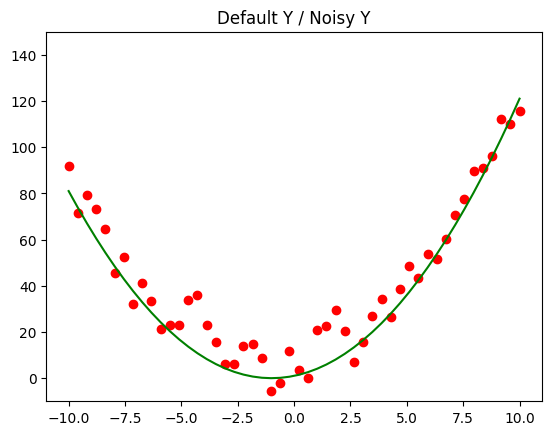

In [7]:
plot_noisy_Y_vs_actual_Y(default_x, default_y, noisy_y)

**Now let's attempt to manually fit the curve according to the data**

In [8]:
@interact(a=1.1, b = 1.1, c = 3.1)
def plot_generic_quad(a,b,c, plot=True):
    new_y = quad_funtion(a,b,c, default_x)
    mean = torch.abs(new_y-noisy_y).mean()
    if plot:
        plot_noisy_Y_vs_actual_Y(default_x, new_y.detach().numpy(), noisy_y)
        plt.title(f"Trying to fit a curve to the data\nError: {mean}")
    return mean

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

**Now we can automate this using torch's gradient descent to fit the curve by iteratively adjusting the parameters to minimize the difference between the predicted/noisy values and the actual data points.**

**But we need an approximation function/model which can fit any continuous function, and it is called ReLU (Rectified Linear Unit).**

**ReLU (Rectified Linear Unit) is a mathematical function used in neural networks. It outputs the input value if it's positive, and zero otherwise.**

In [9]:
def relu(m,c,x):
    y = (m*x)+c
    return torch.clip(y,0.0)

**But by stacking multiple ReLUs, we can achieve something remarkable: the stacked ReLUs can approximate any given continuous function given enough time and a sufficient number of layers (or for now, we can use ReLU)..**

**I have stacked 5 ReLU units so that we can fit the quadratic function.**

In [10]:
def relu_parameters(m0,c0,m1,c1,m2,c2,m3,c3,m4,c4):
    x = default_x
    return relu(m0, c0, x) + relu(m1, c1, x) + relu(m2, c2, x) + relu(m3, c3, x) + relu(m4, c4, x)
        

In [11]:
def plot_relus_vs_noisy_Y(*args):
    new_y = relu_parameters(*args)
    mean = torch.abs(new_y-noisy_y).mean()
    plot_noisy_Y_vs_actual_Y(default_x, new_y.detach().numpy(), noisy_y)
    plt.title(f"Attempting to fit a curve (using 5 stacked ReLU units) to the data.\nError: {mean}")
    return mean

**At this stage, you may watch some introductory videos about how PyTorch and gradient descent work (if you're not already familiar with them).**  

In [12]:
torch.manual_seed(47) # so that the results remain constant
parameters = torch.rand(10)
parameters.requires_grad_()

tensor([0.0530, 0.0499, 0.4677, 0.8757, 0.5561, 0.7984, 0.9758, 0.2482, 0.1469,
        0.4345], requires_grad=True)

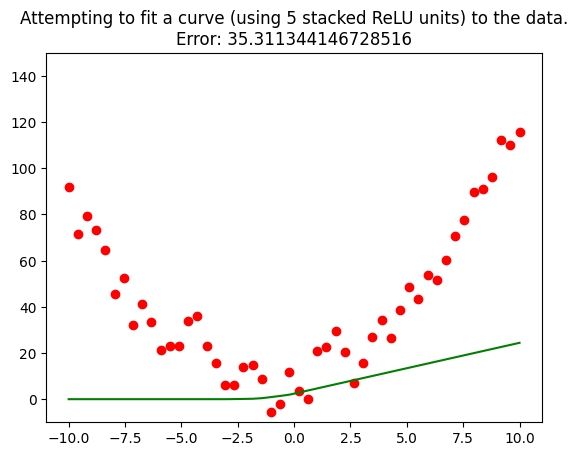

In [13]:
with torch.no_grad():
    plot_relus_vs_noisy_Y(*parameters)

**Now PyTorch will automatically calculate the best parameters to minimize the error using gradient descent.**

I have set the epoch and learning rate arbitrarily for this demo, but in actual models, more sophisticated methods are applied.

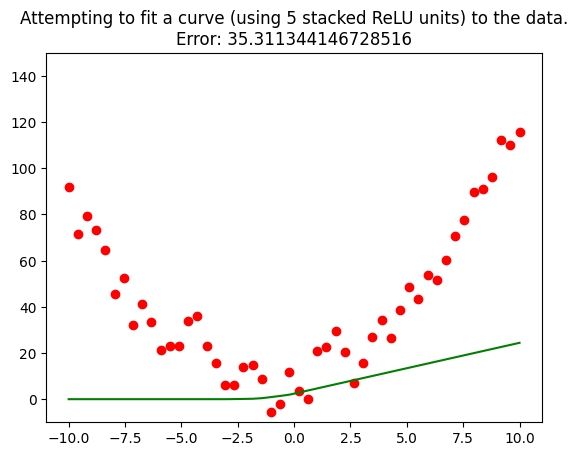

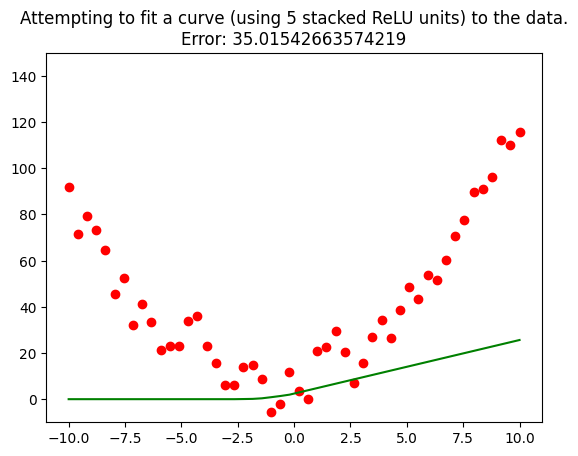

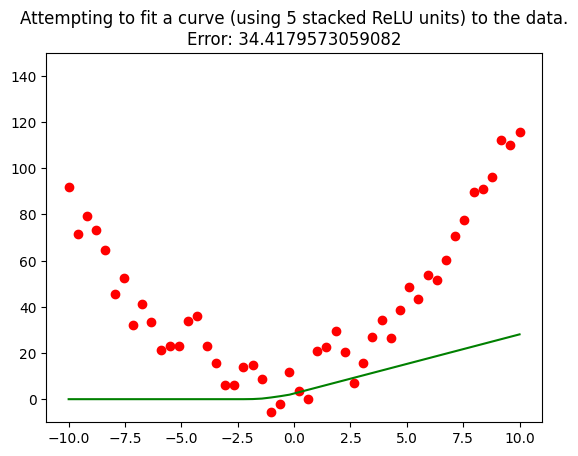

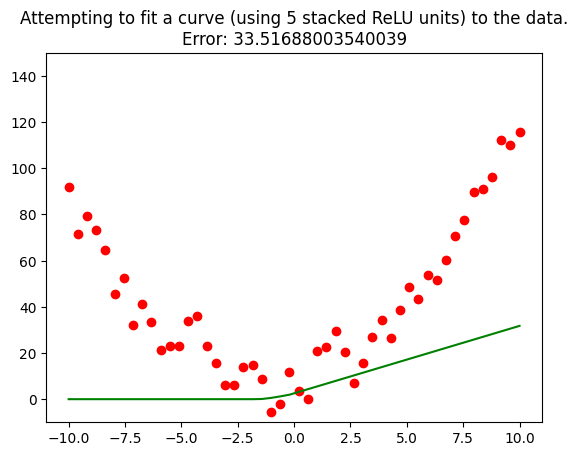

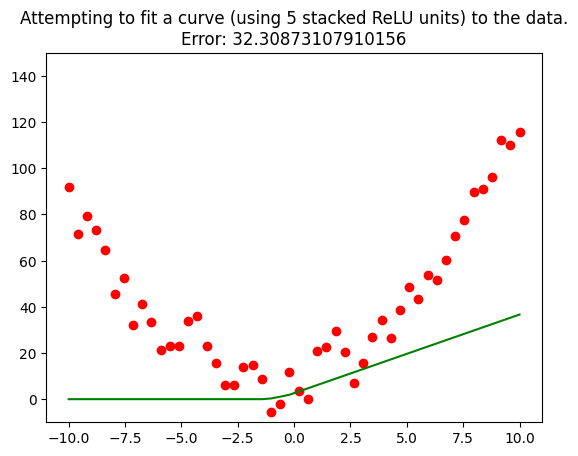

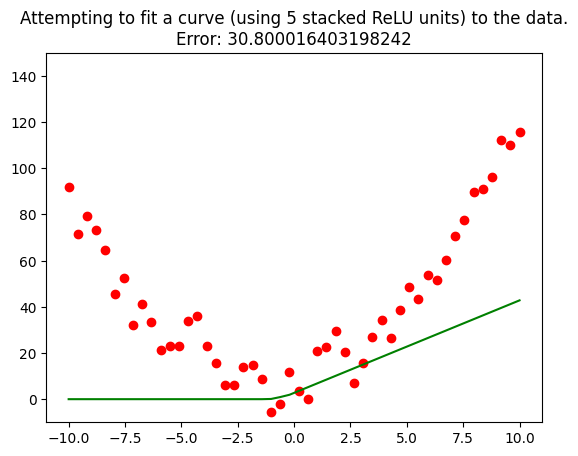

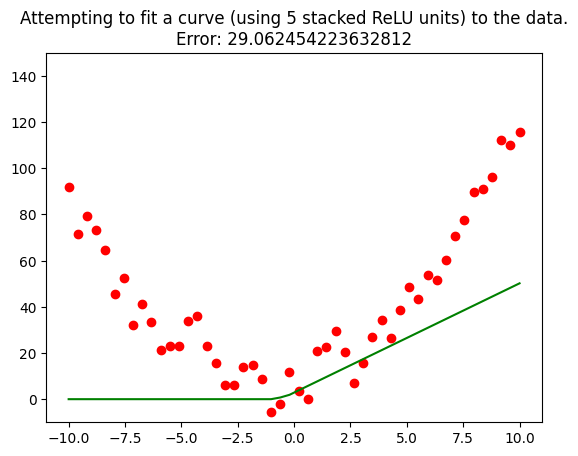

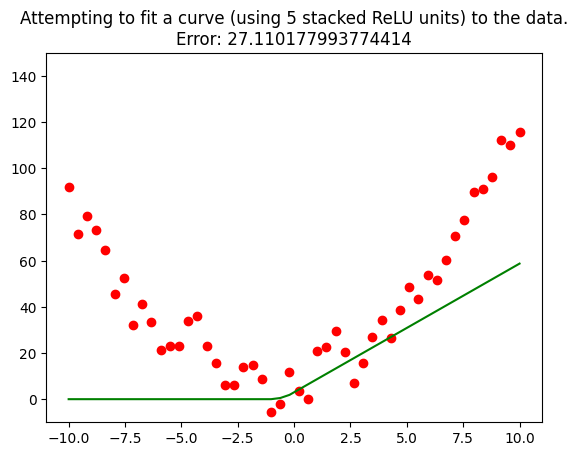

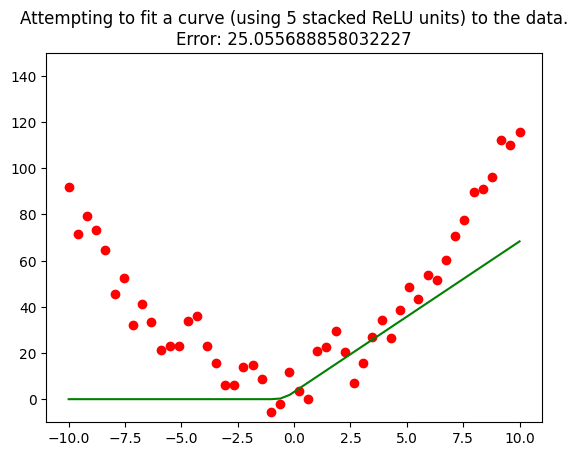

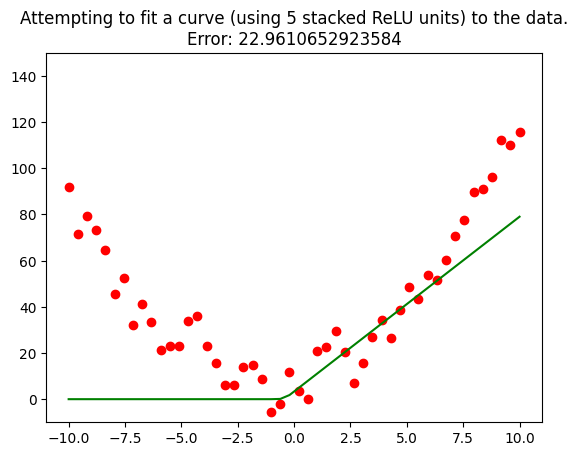

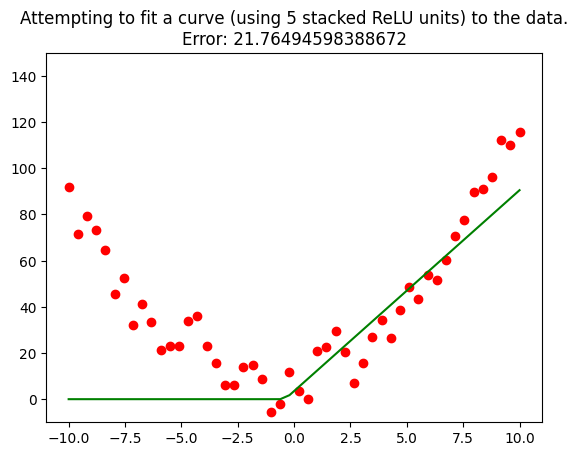

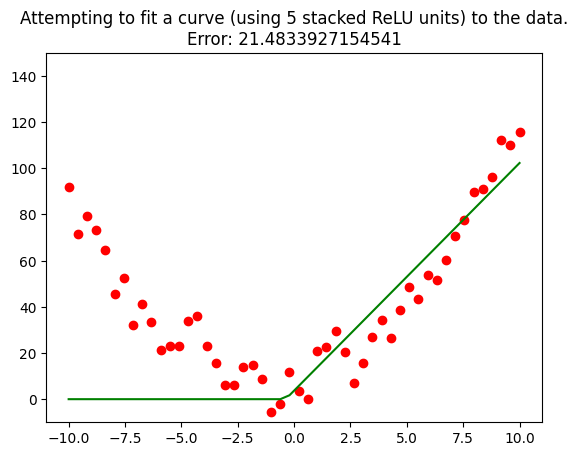

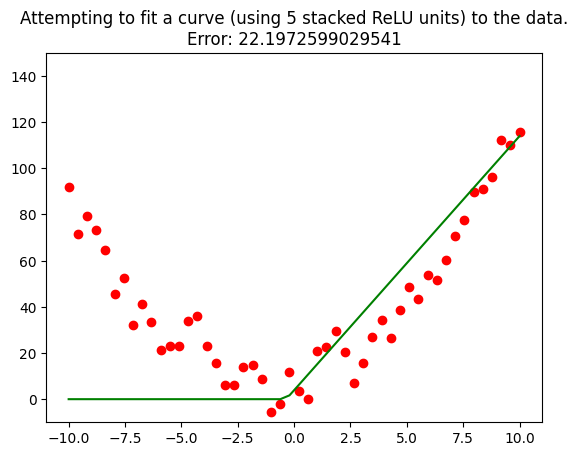

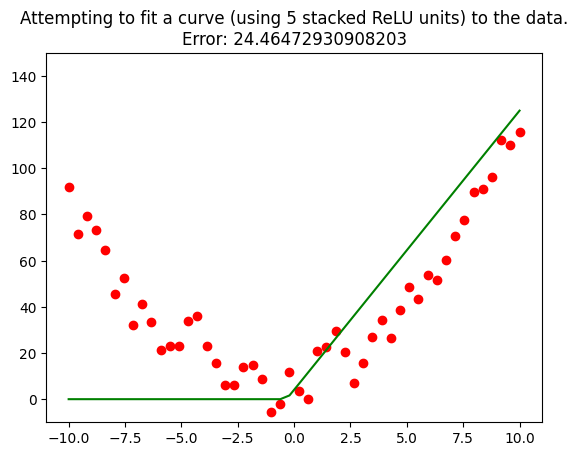

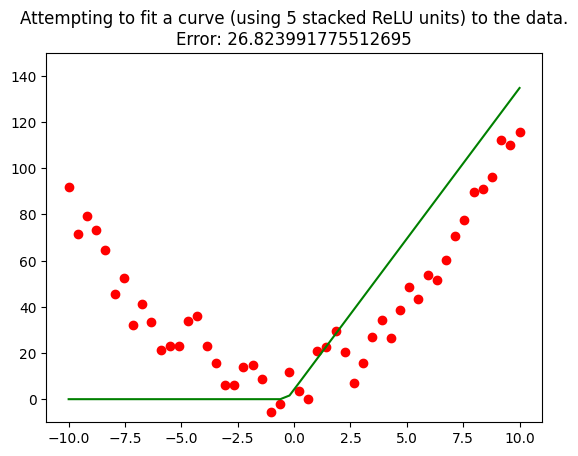

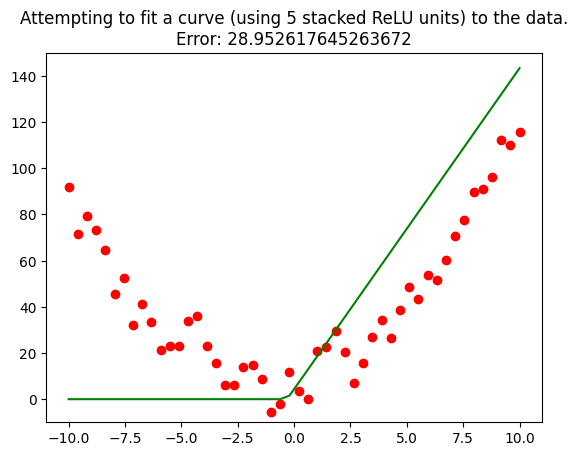

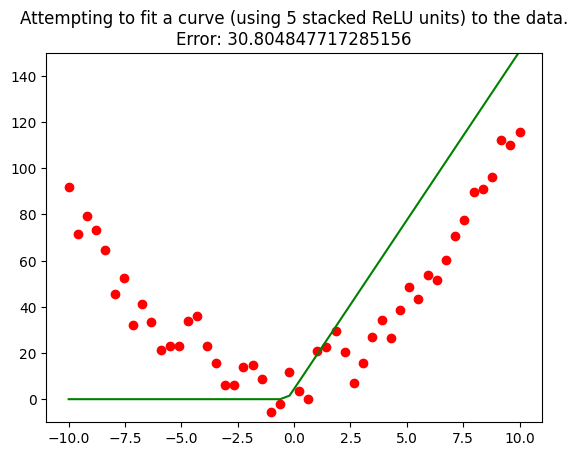

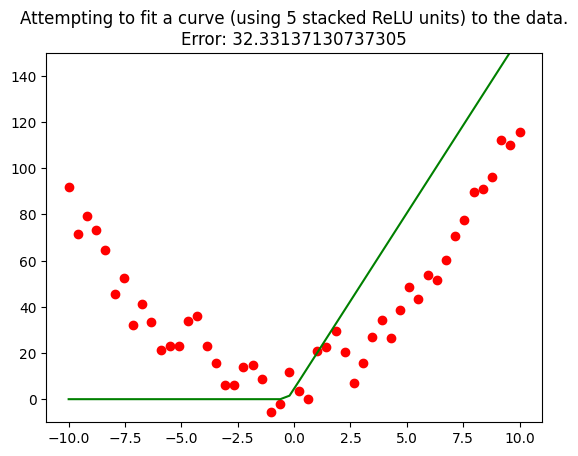

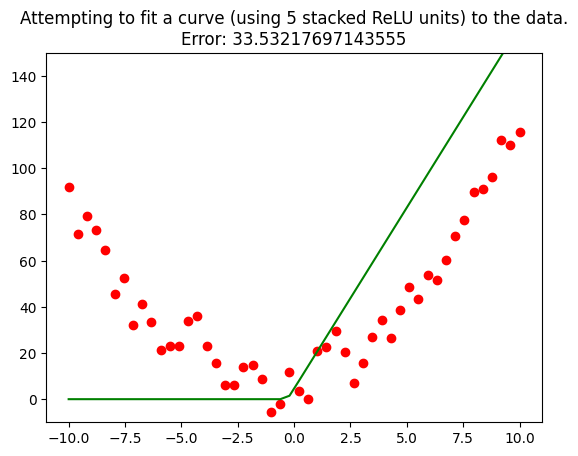

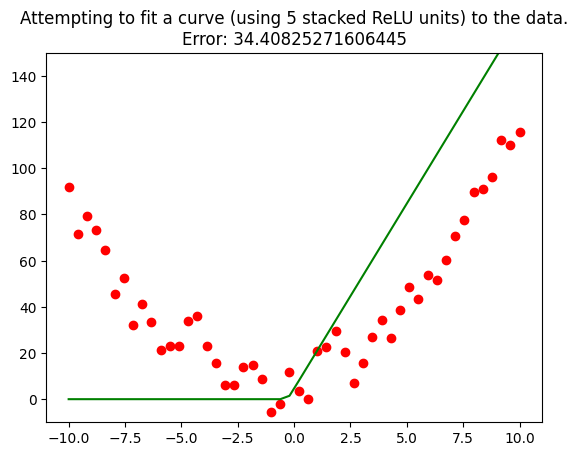

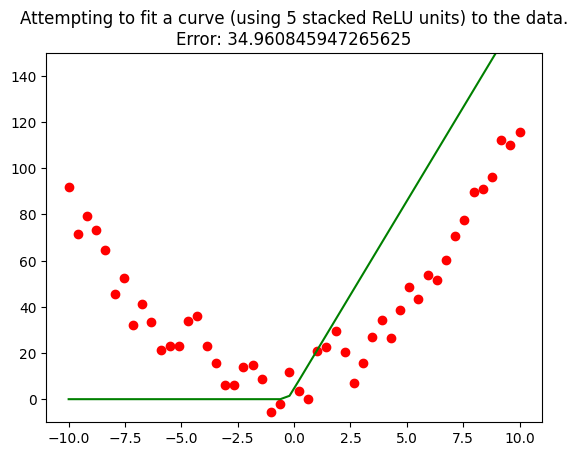

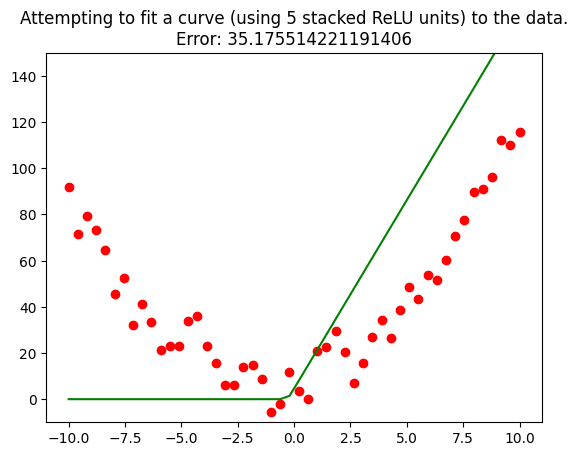

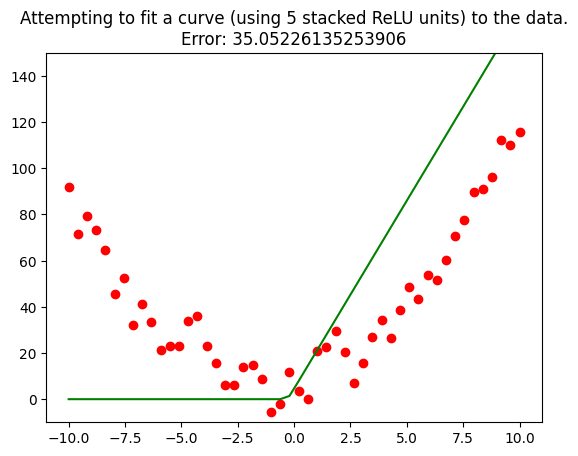

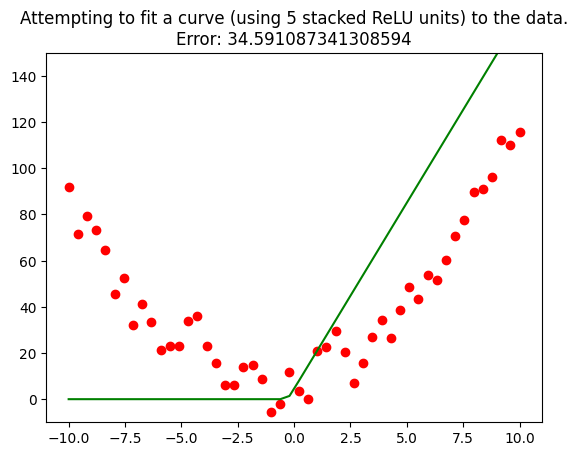

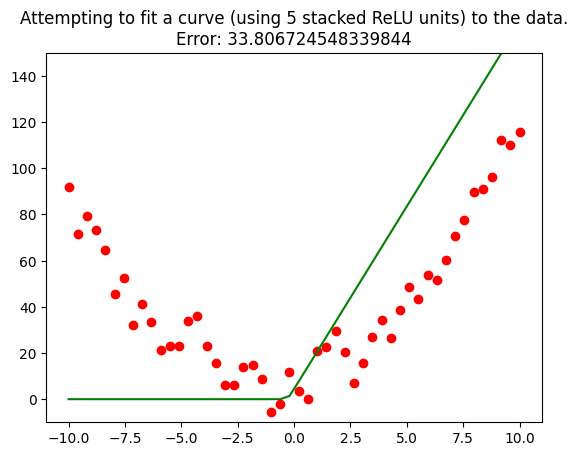

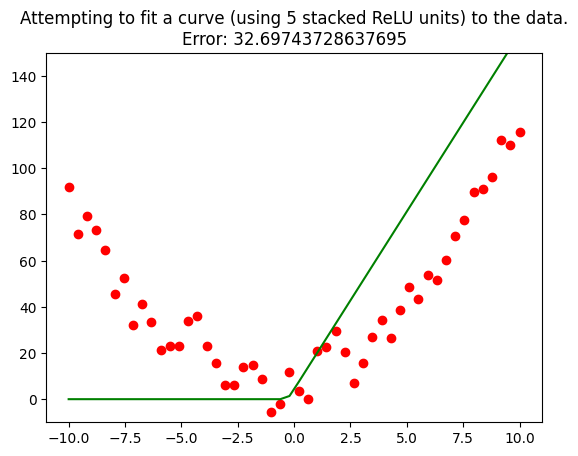

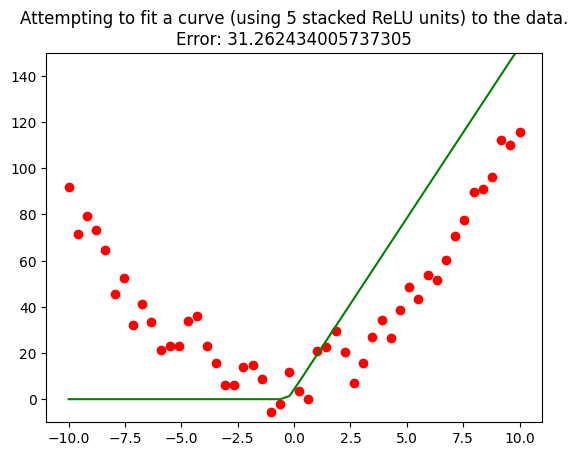

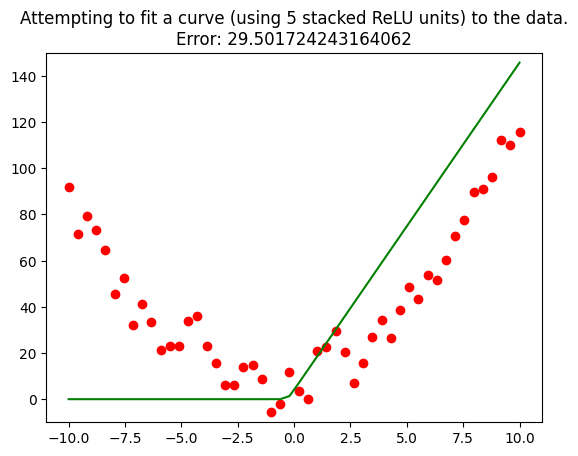

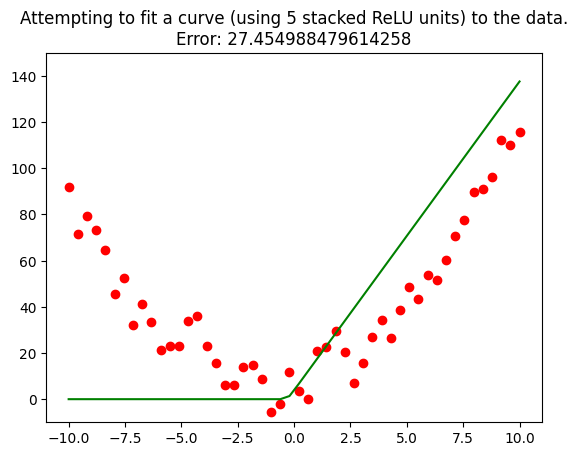

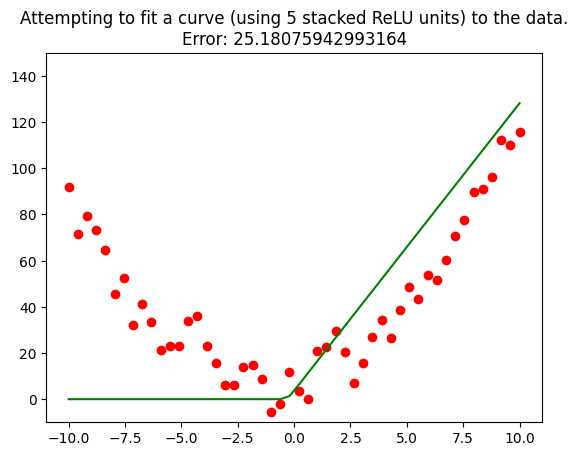

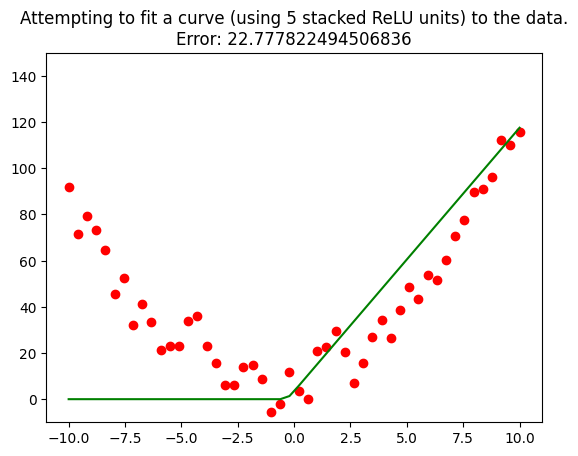

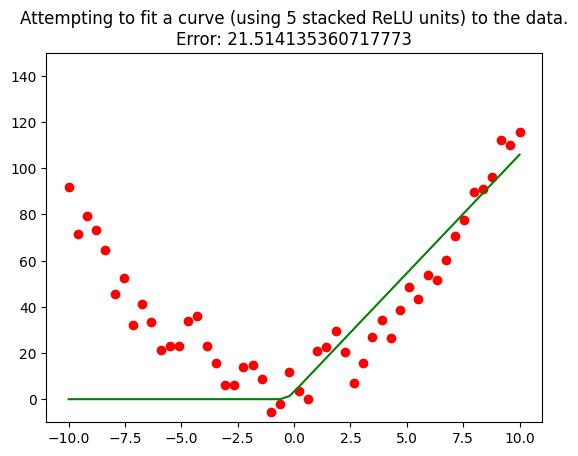

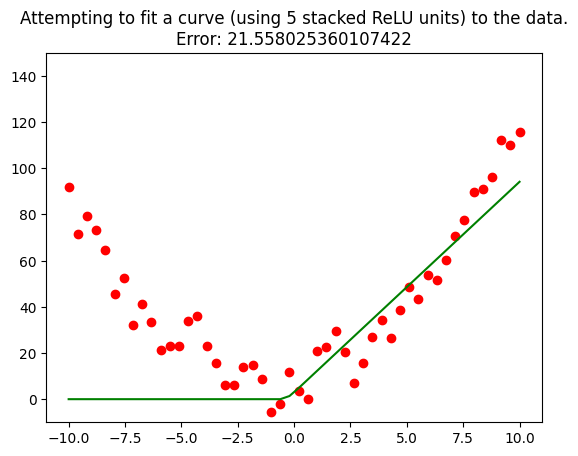

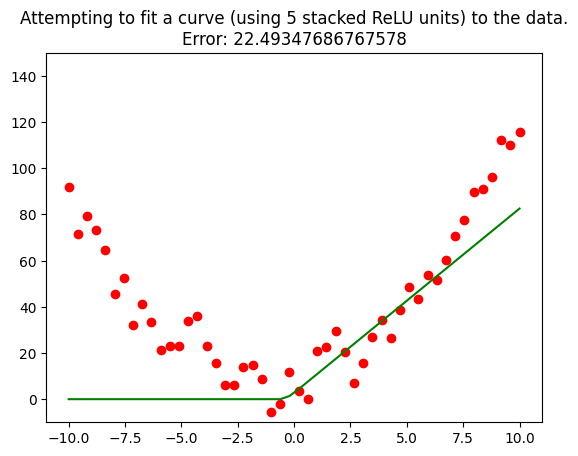

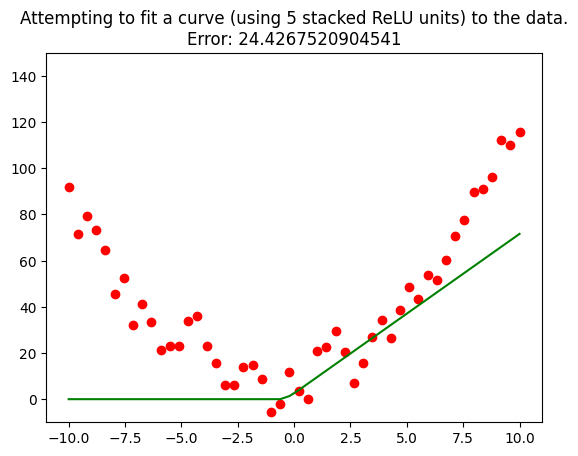

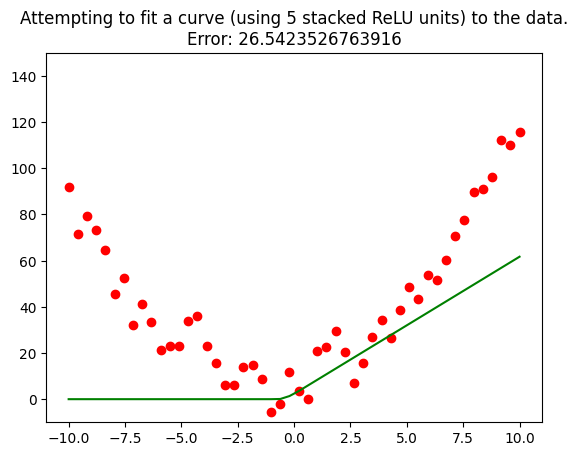

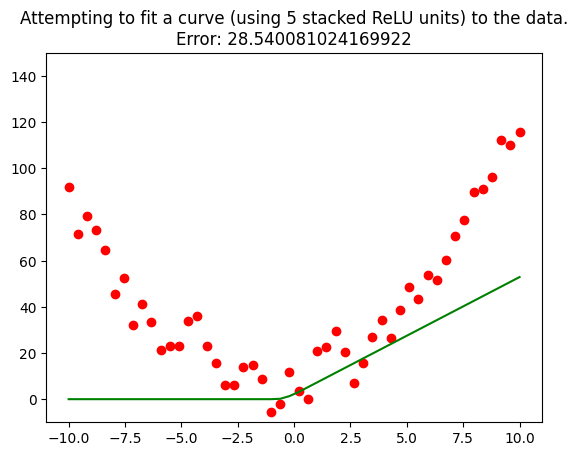

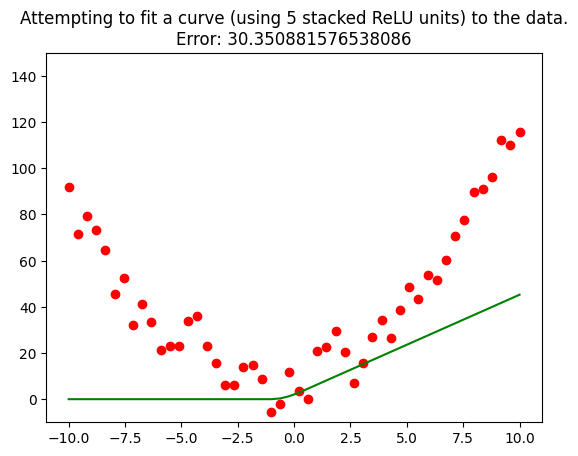

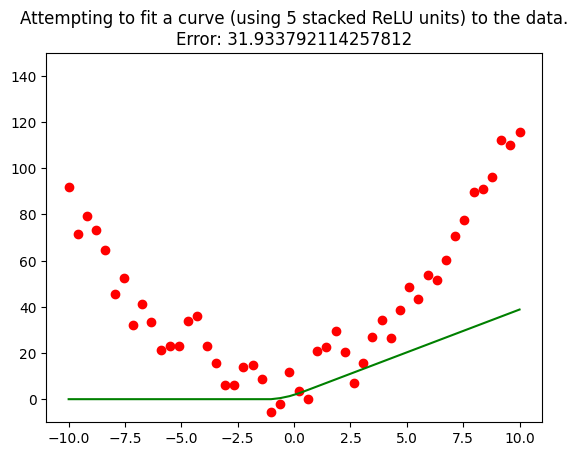

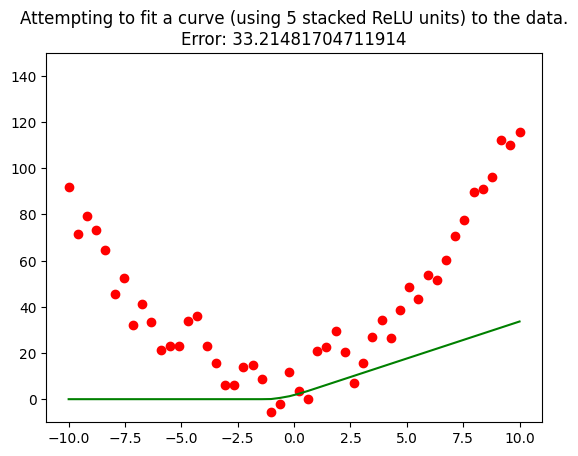

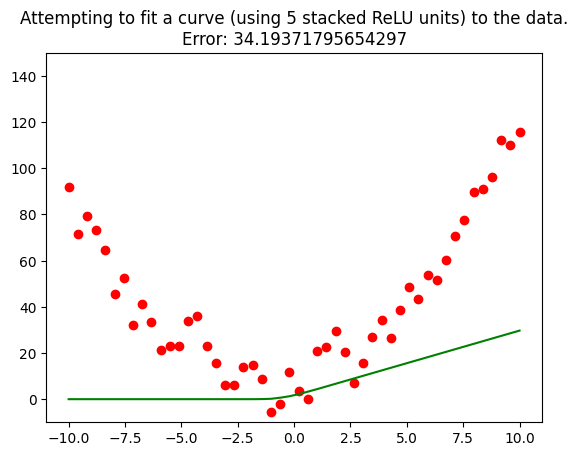

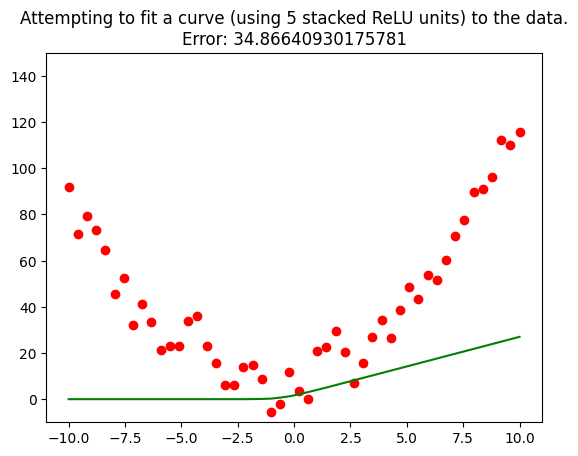

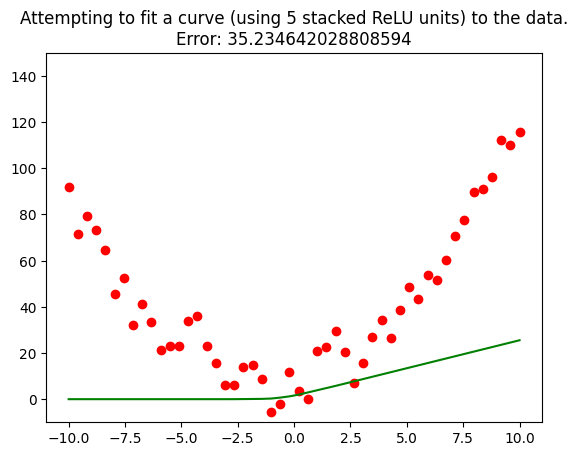

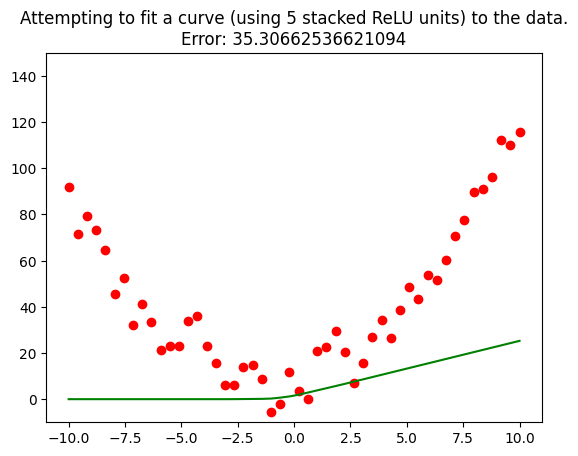

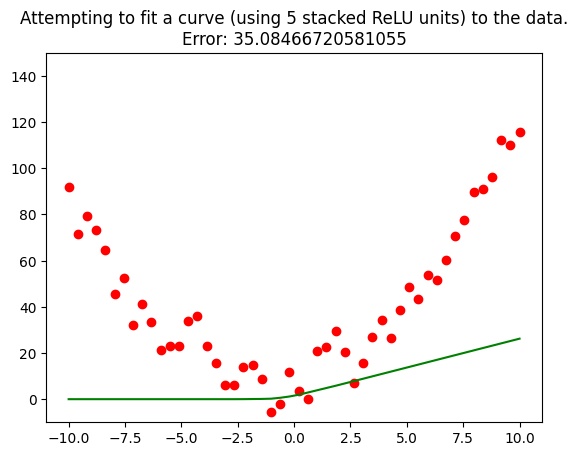

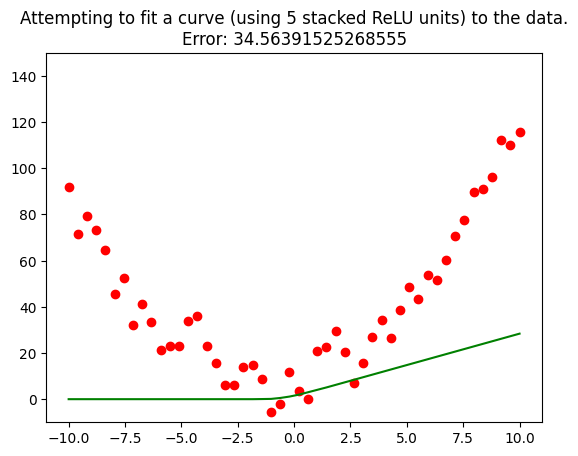

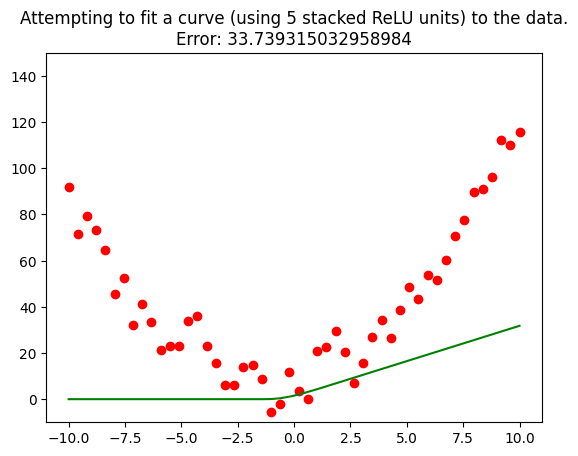

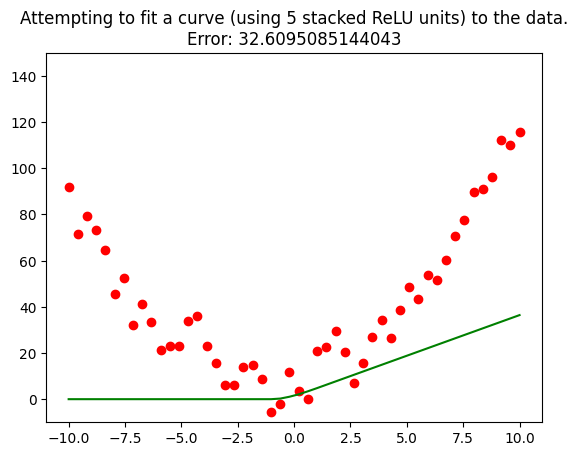

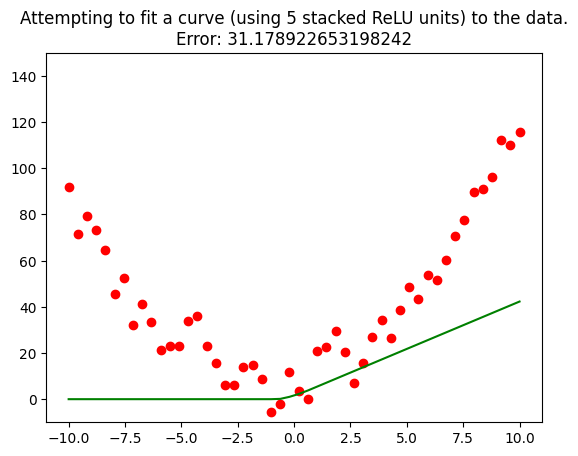

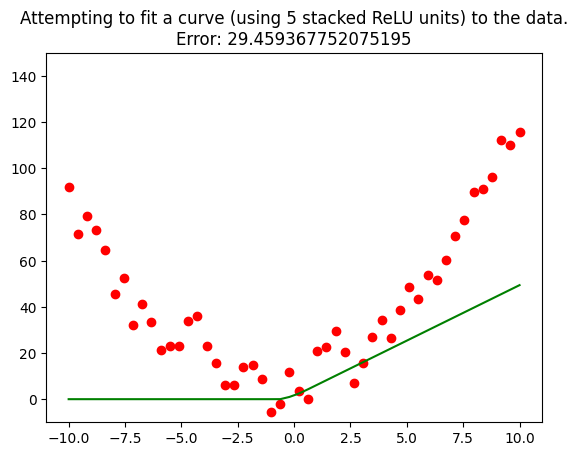

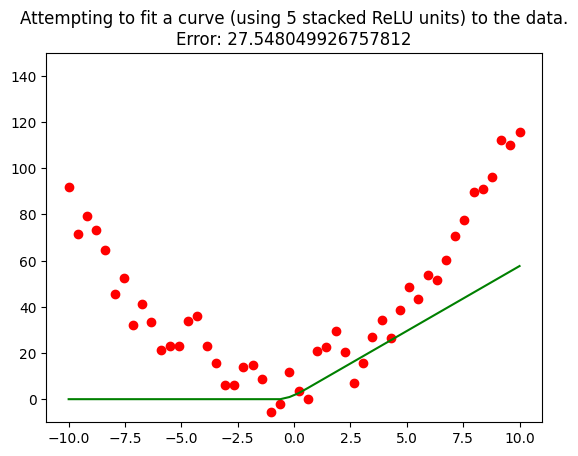

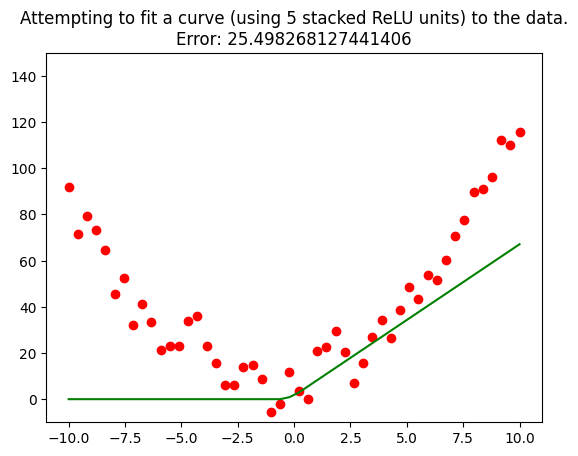

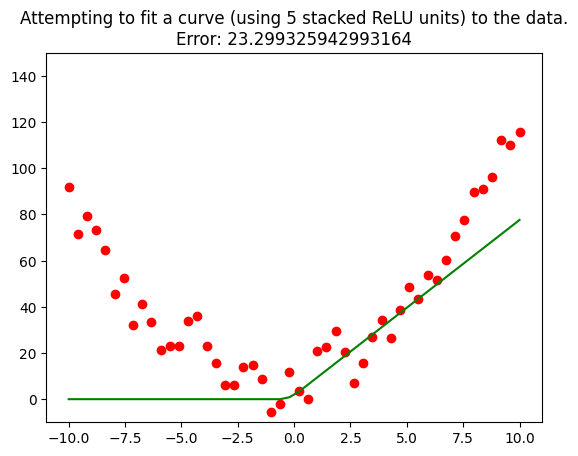

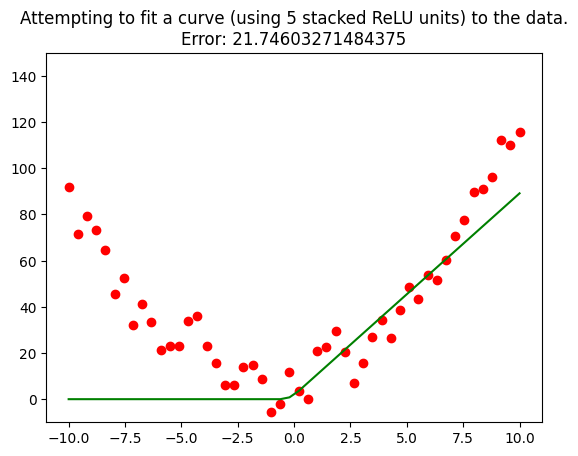

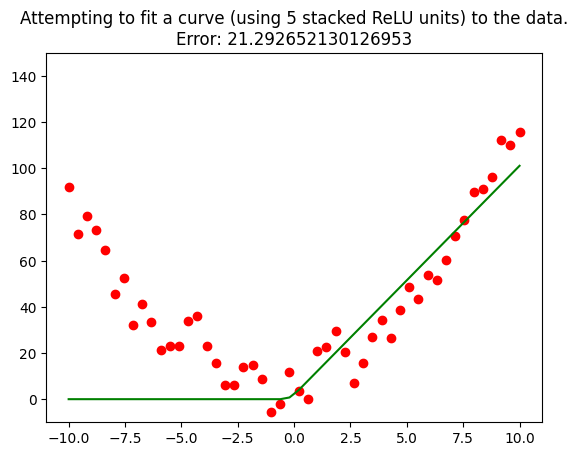

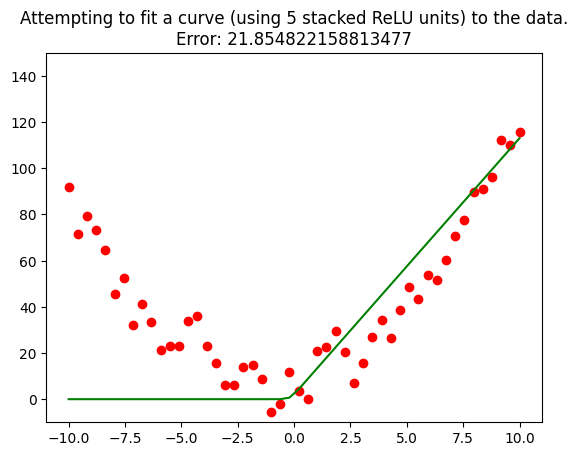

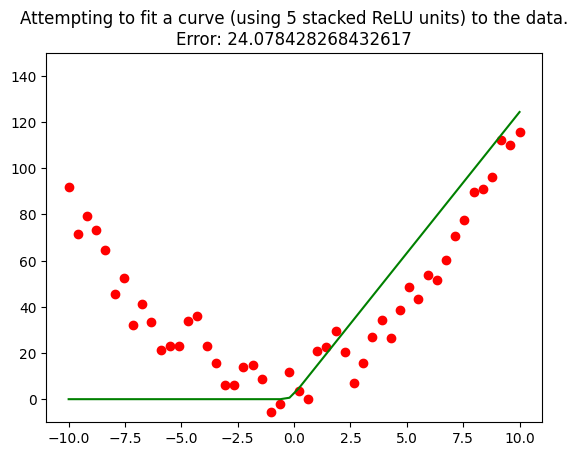

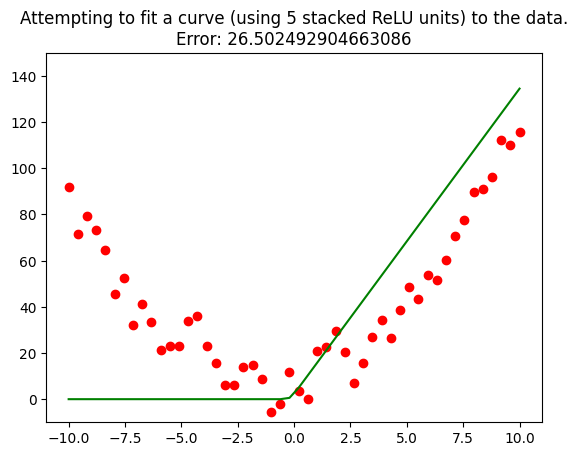

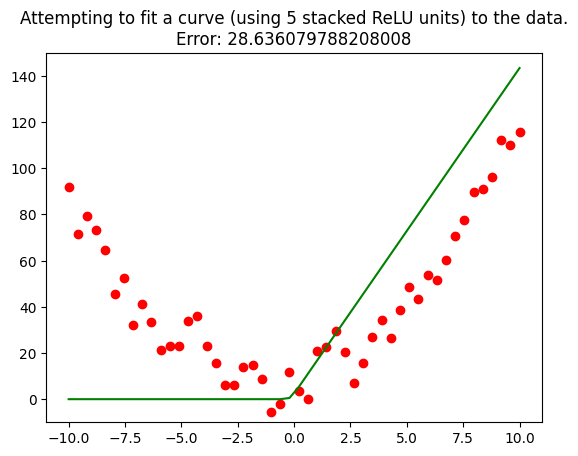

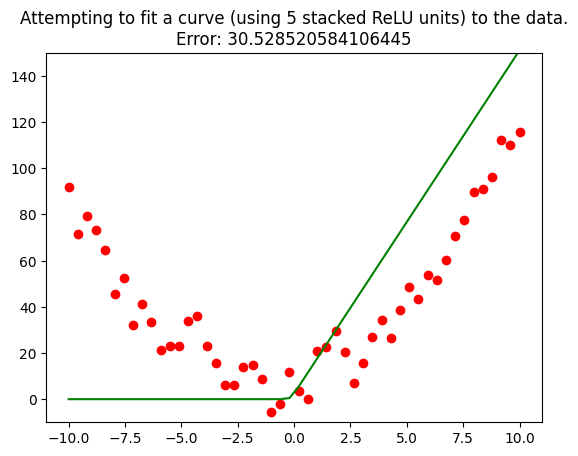

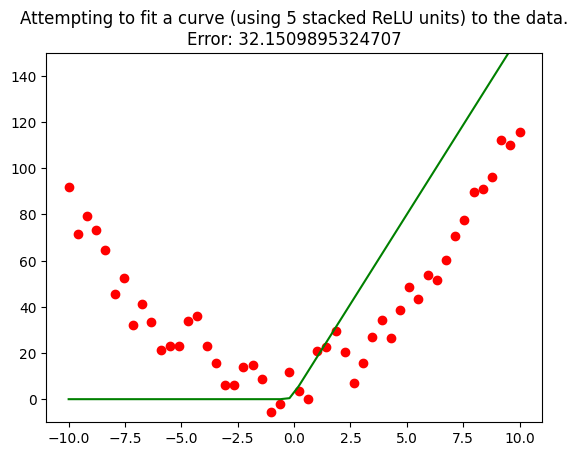

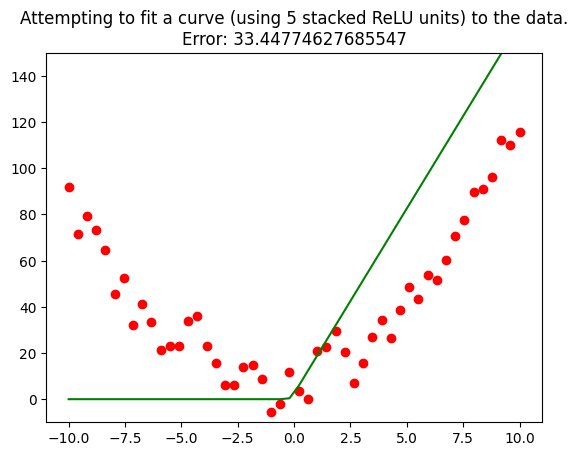

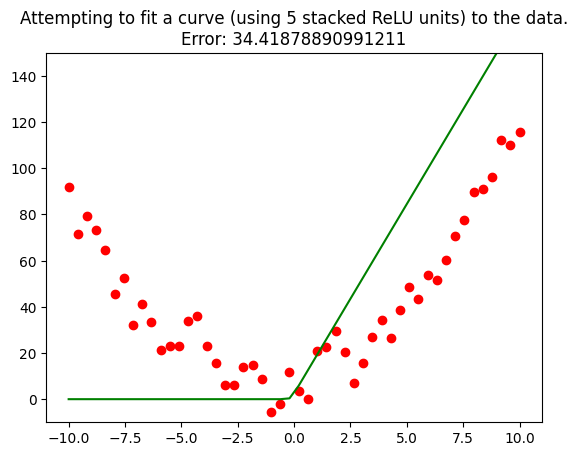

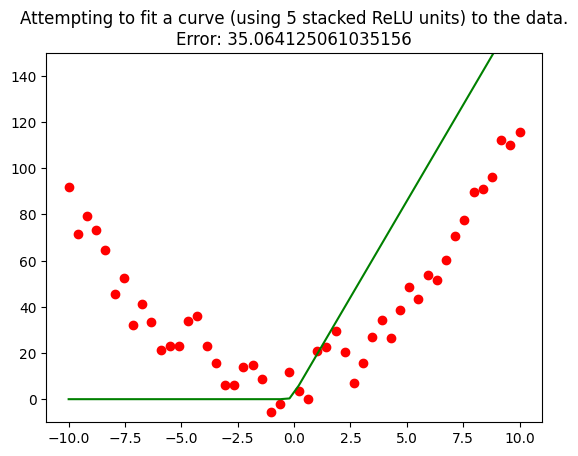

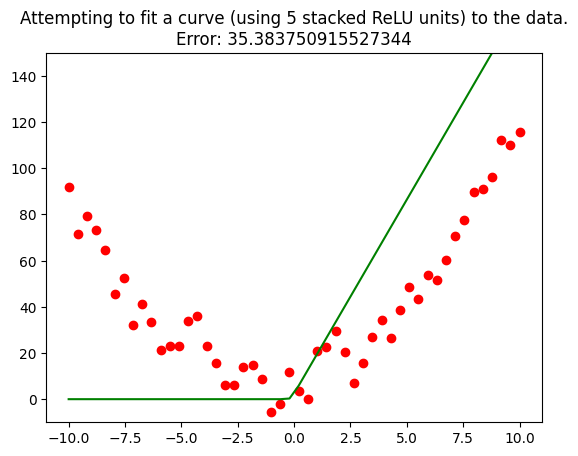

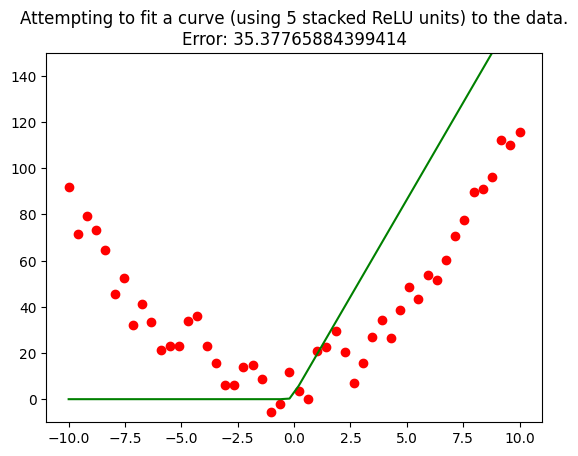

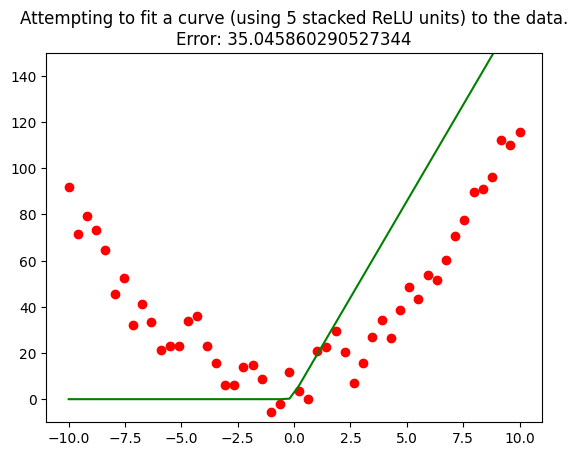

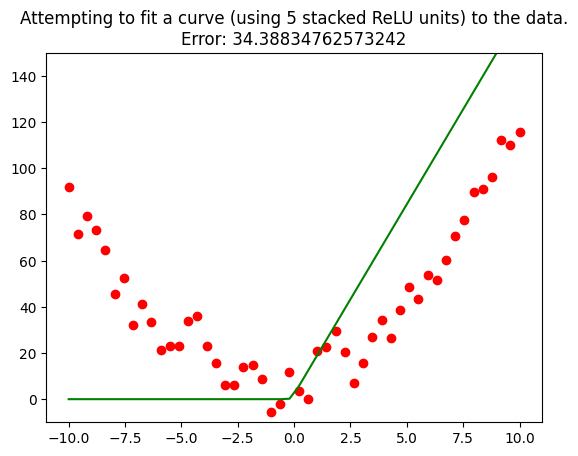

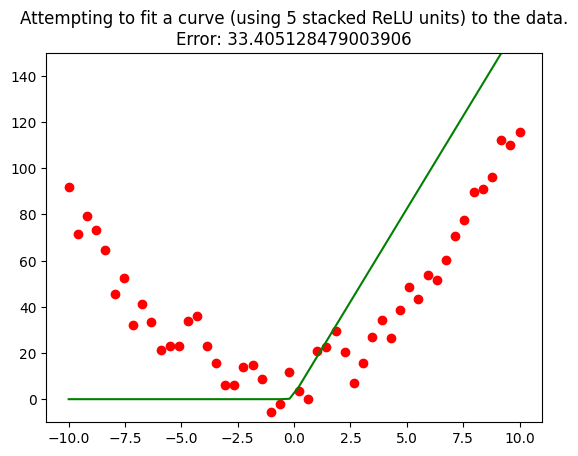

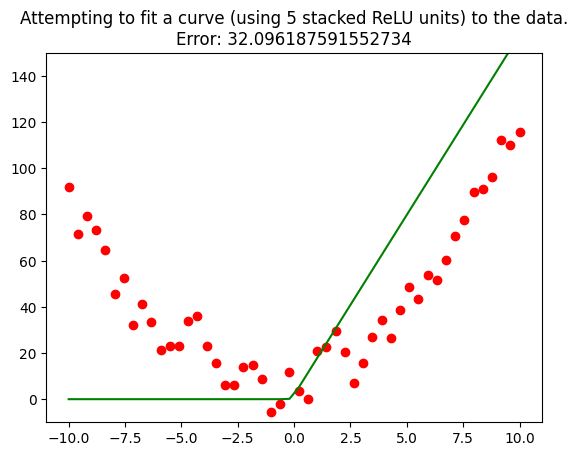

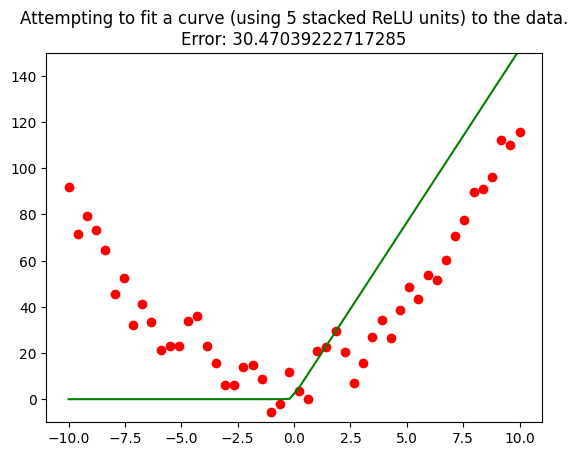

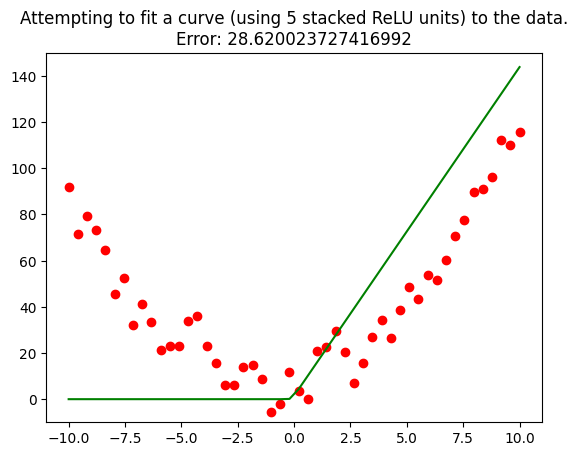

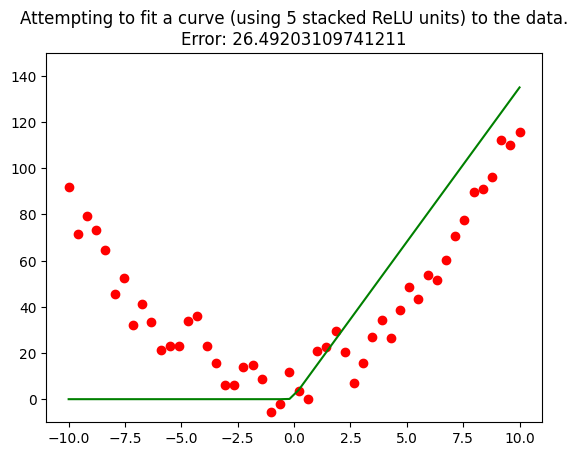

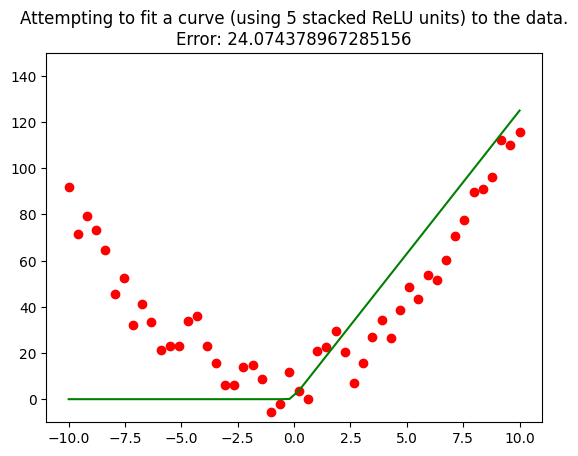

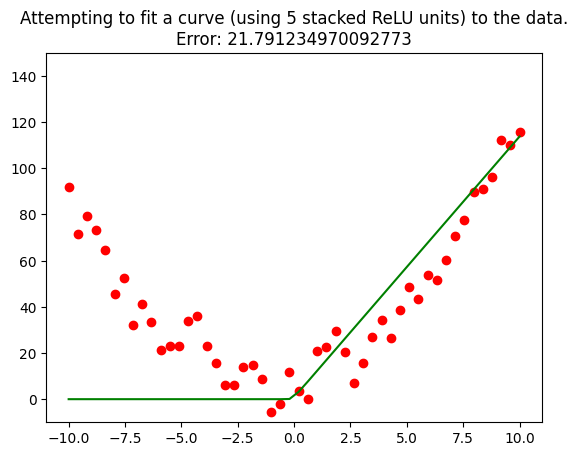

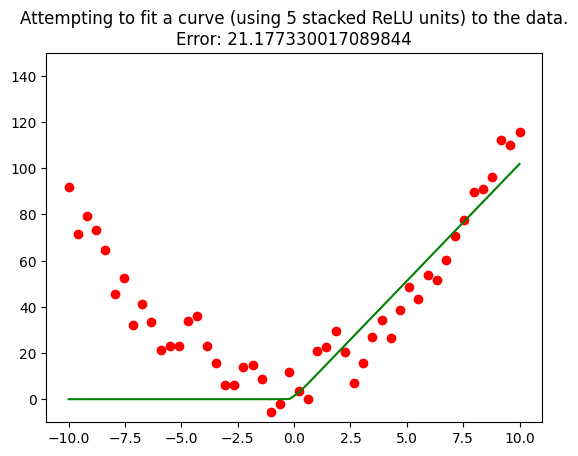

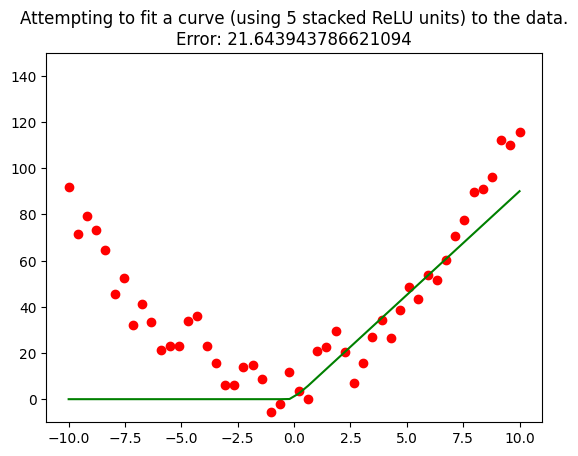

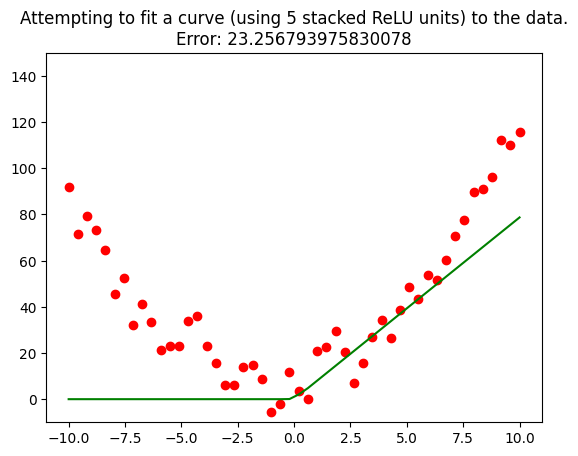

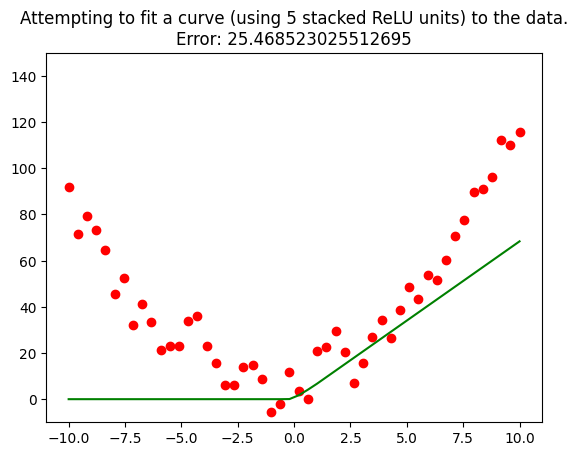

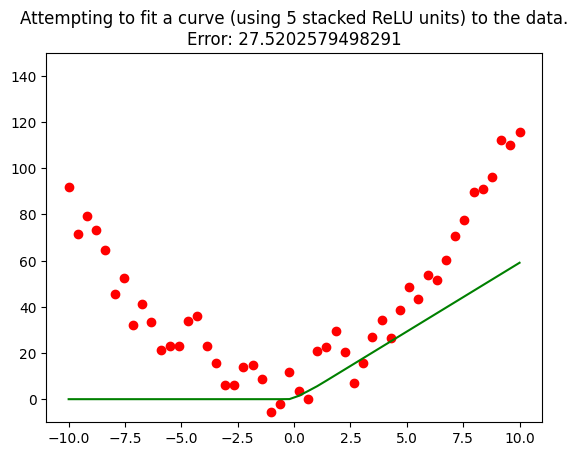

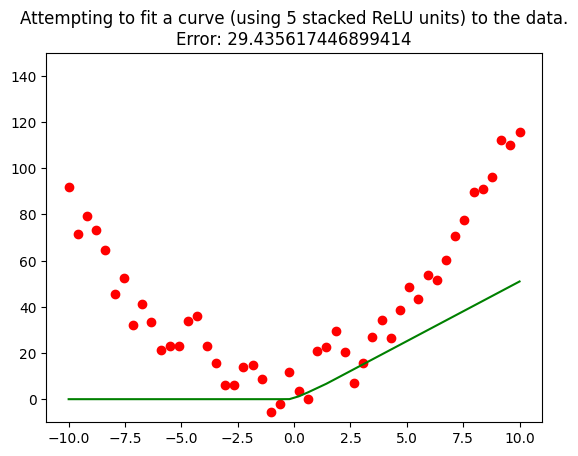

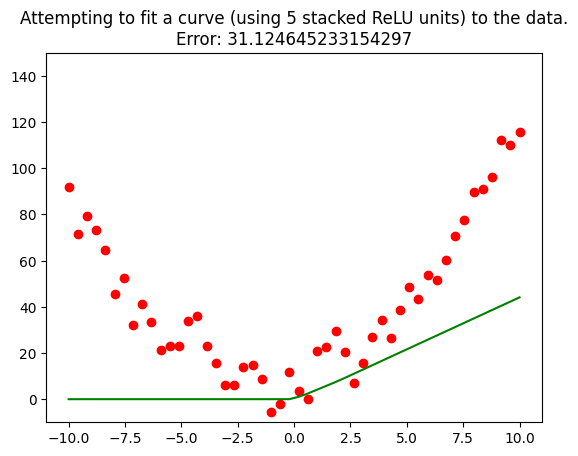

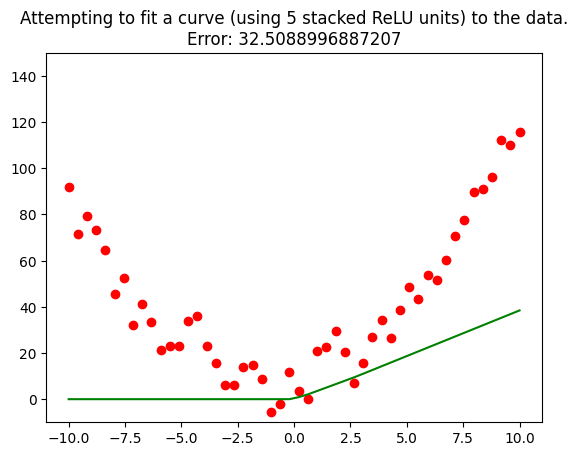

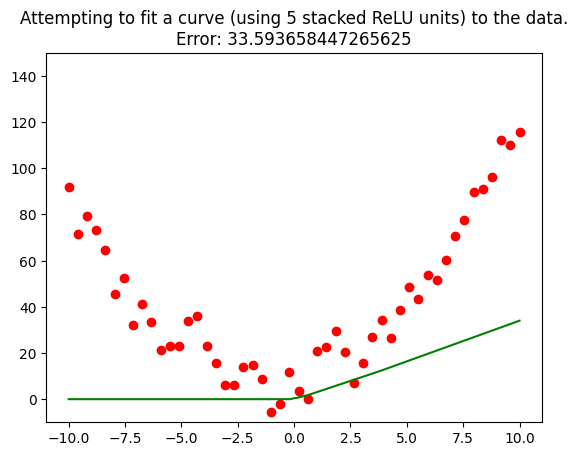

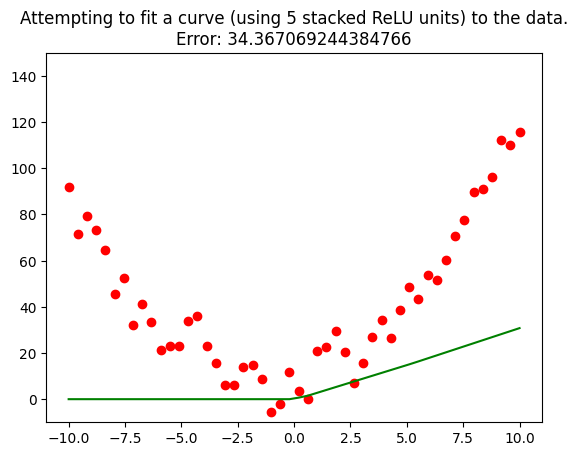

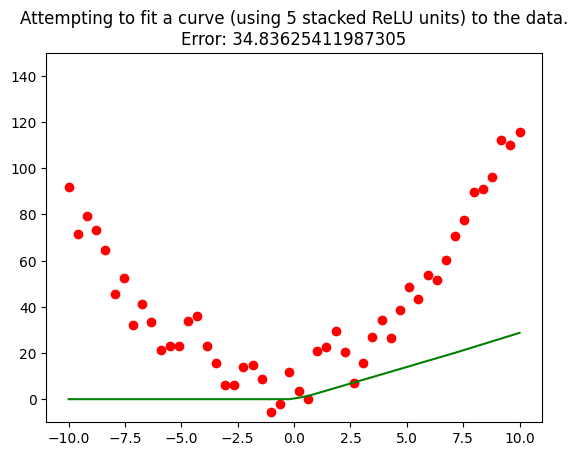

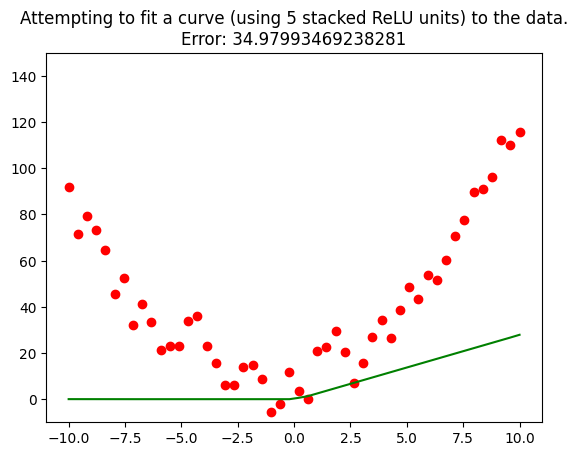

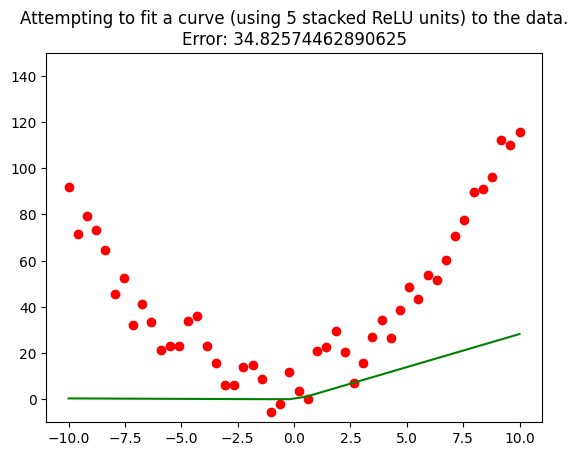

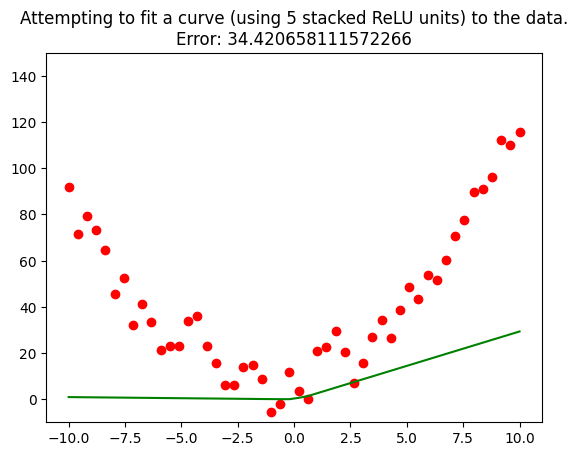

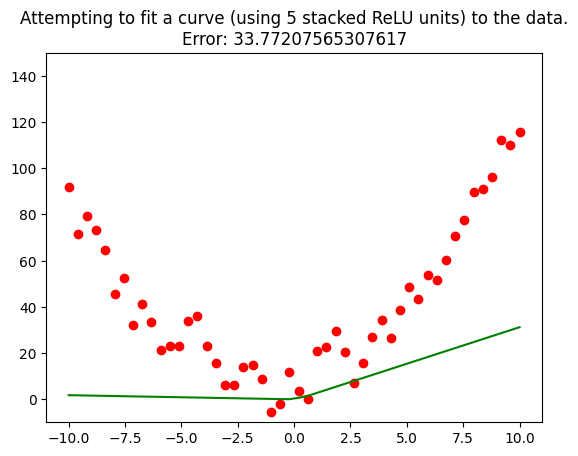

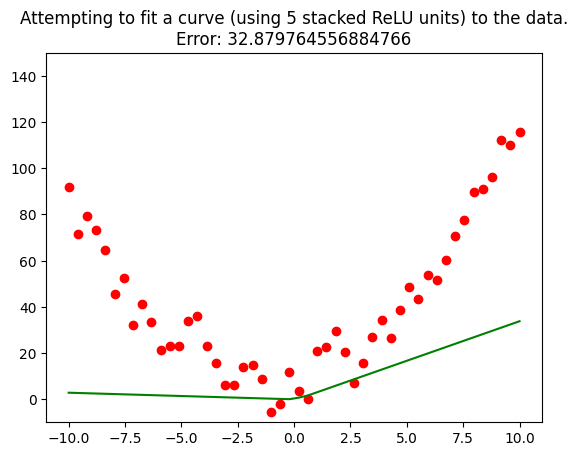

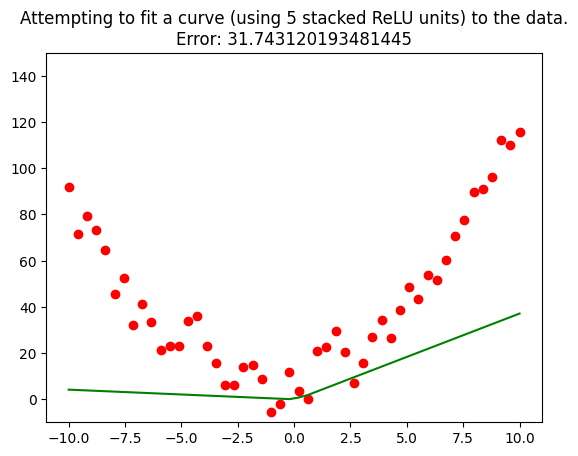

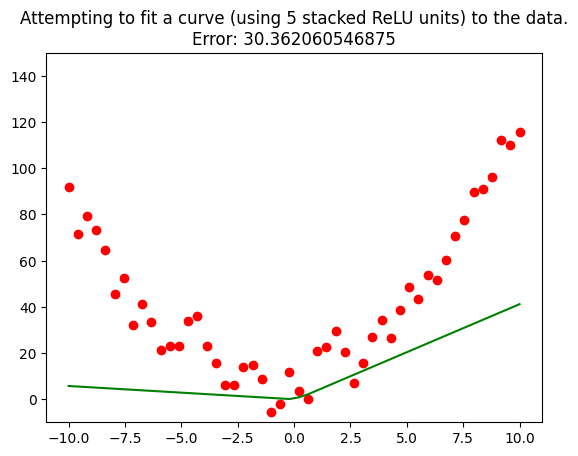

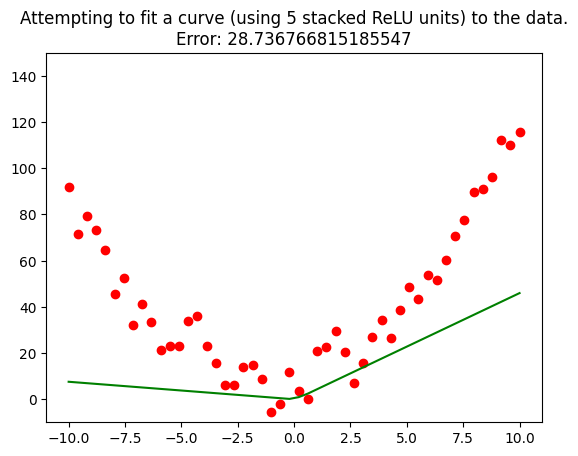

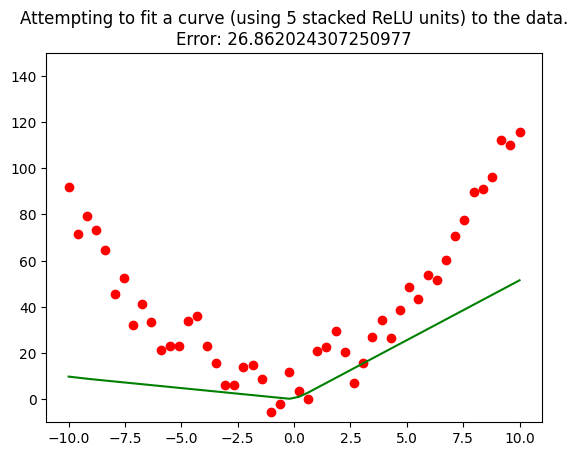

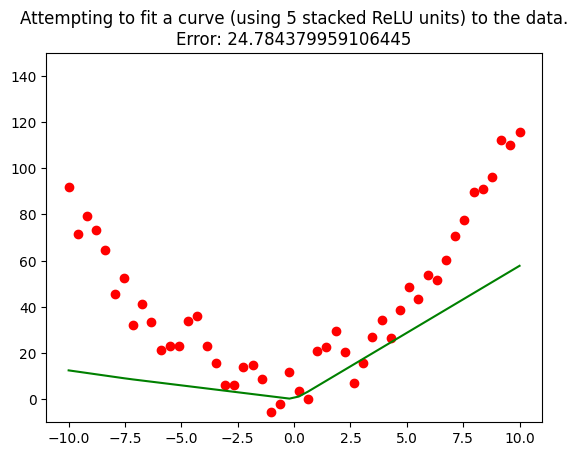

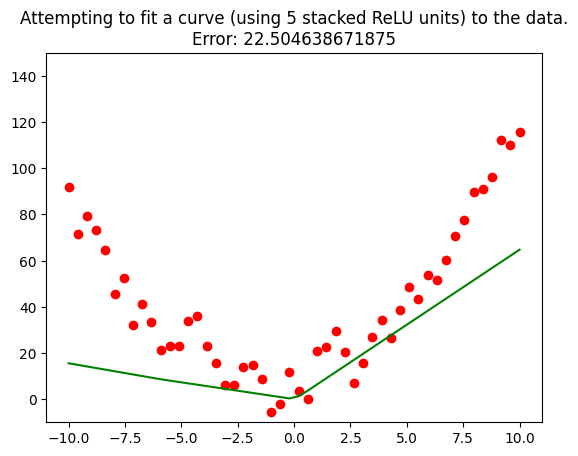

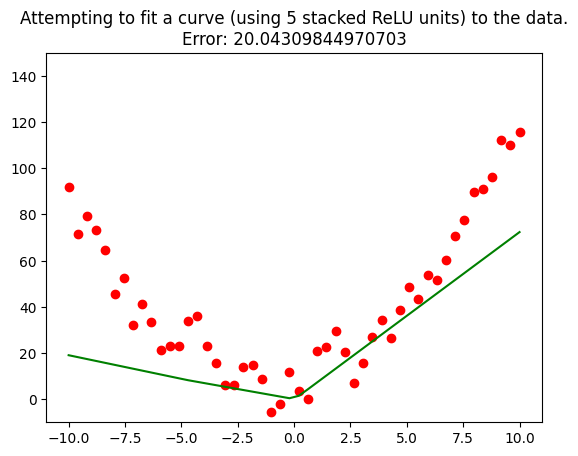

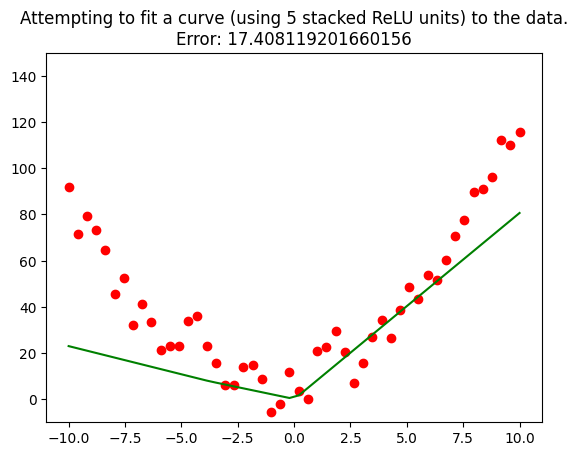

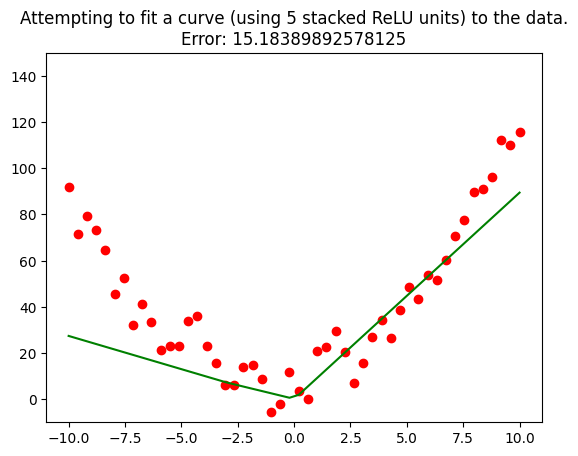

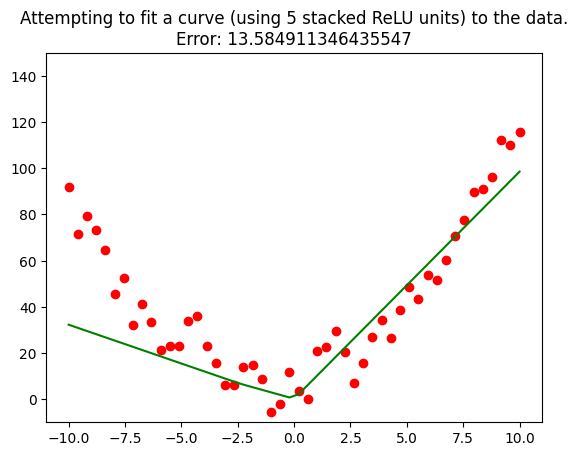

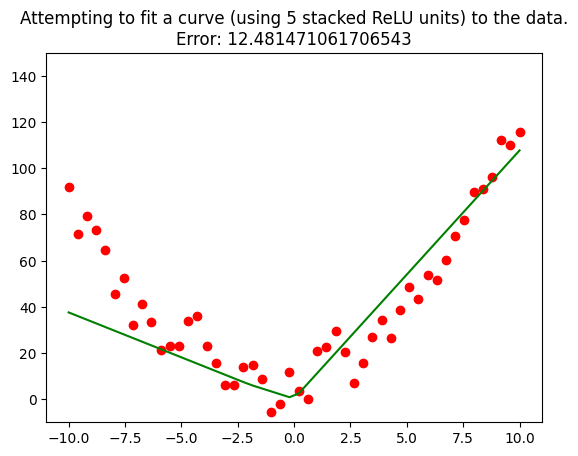

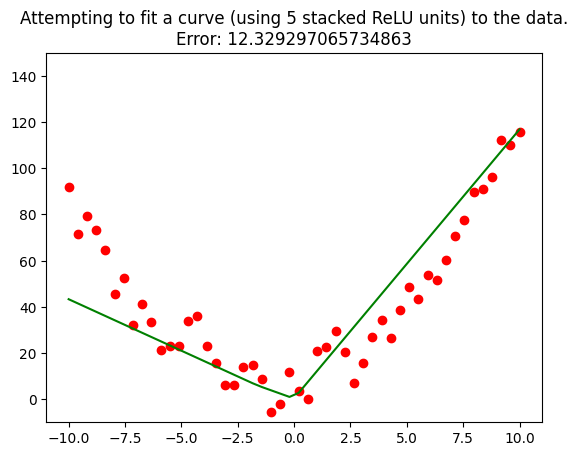

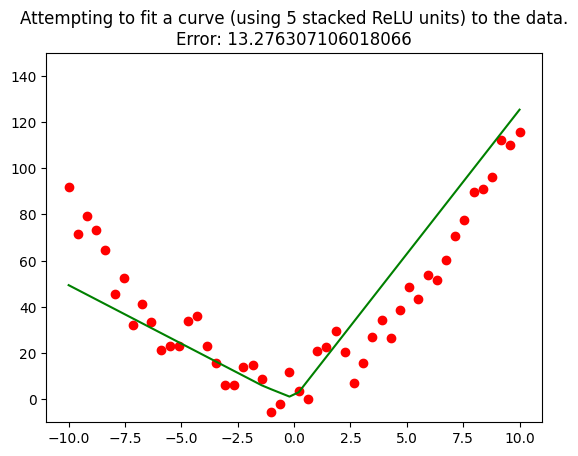

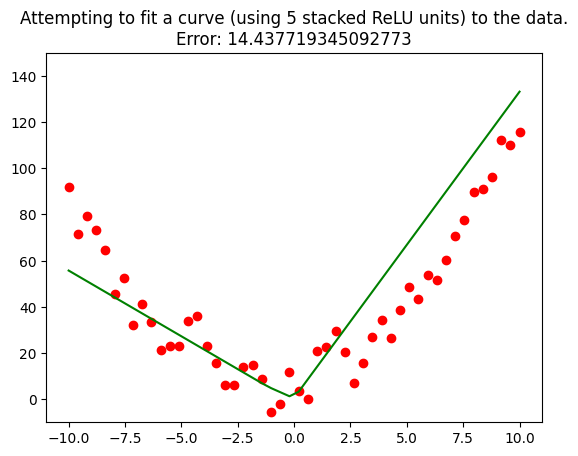

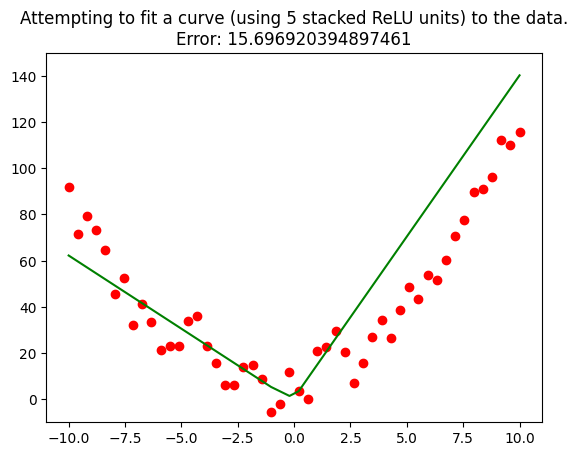

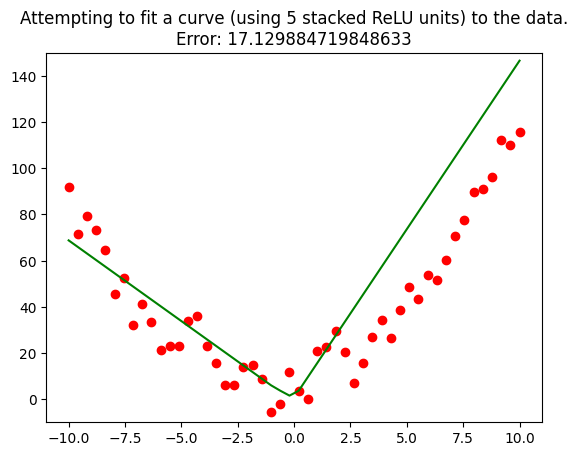

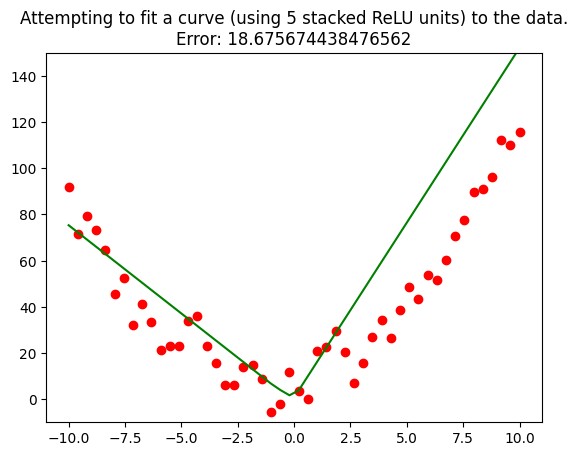

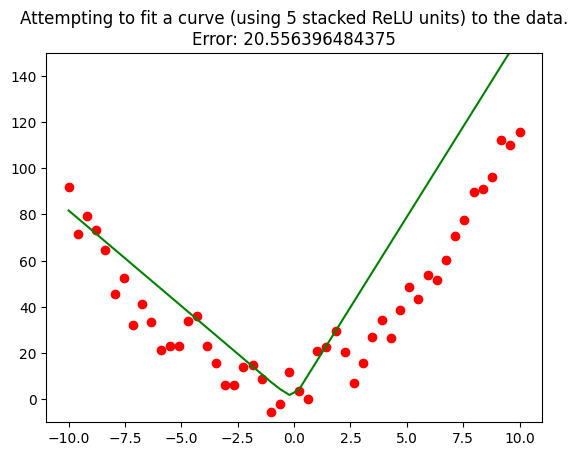

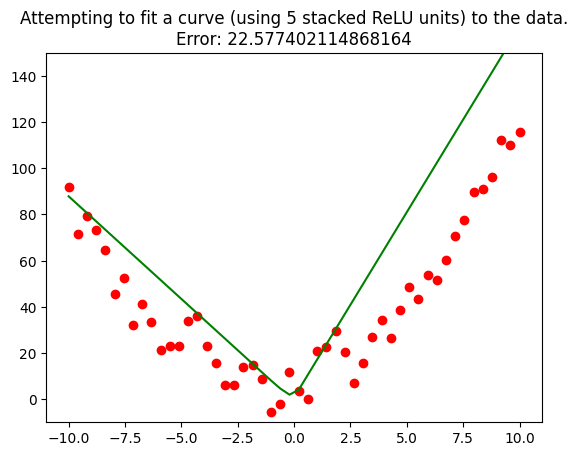

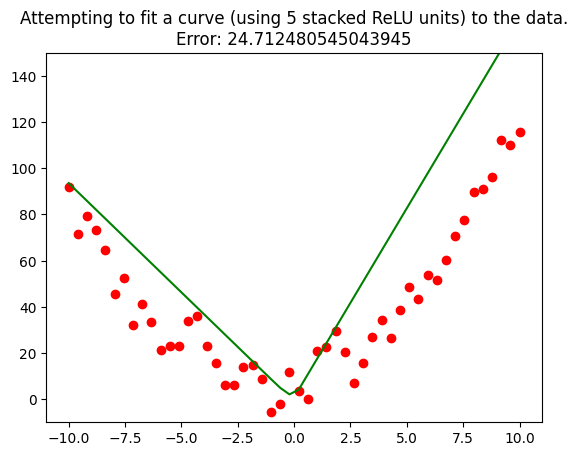

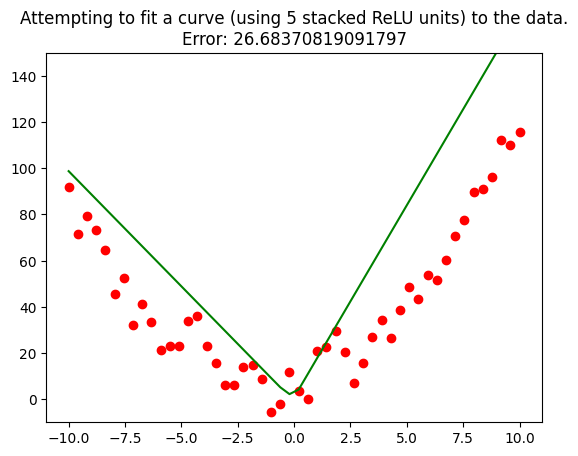

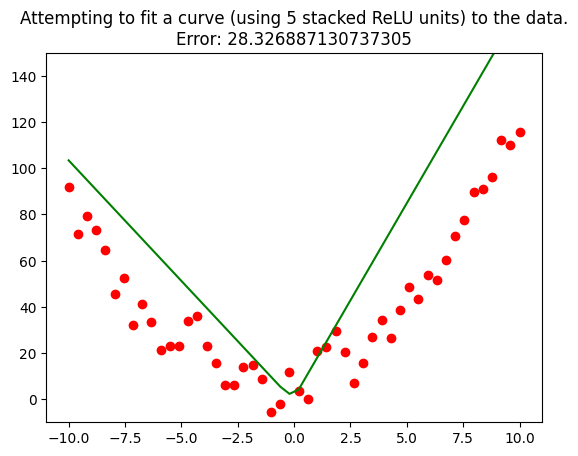

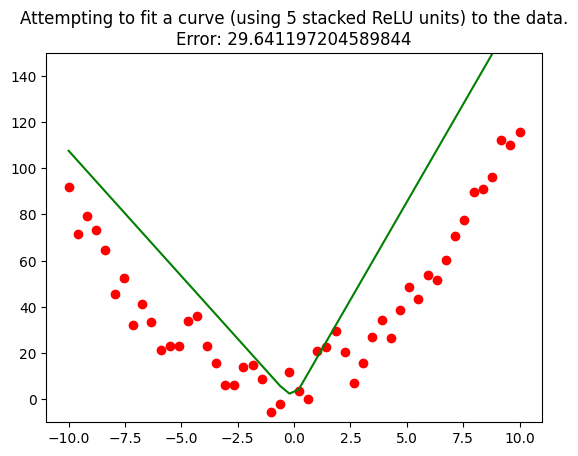

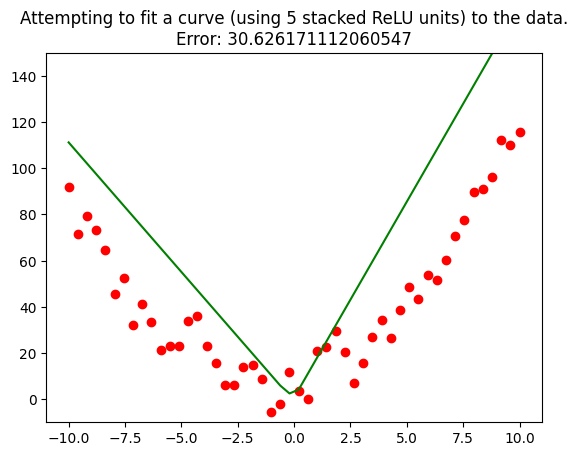

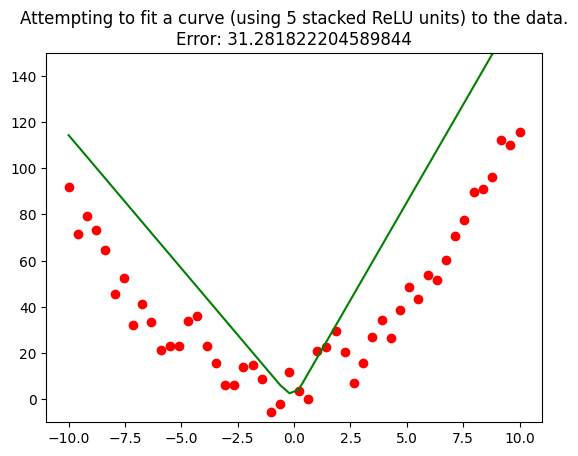

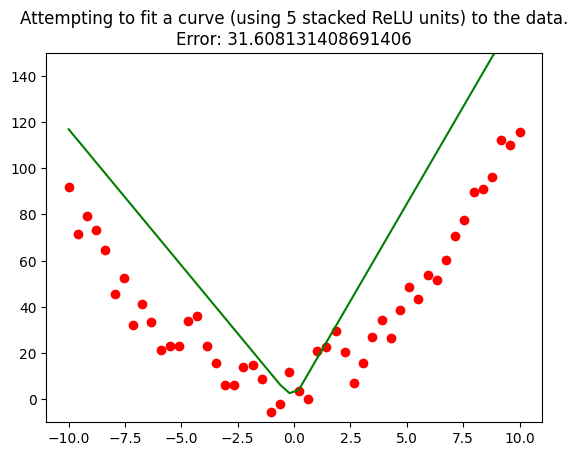

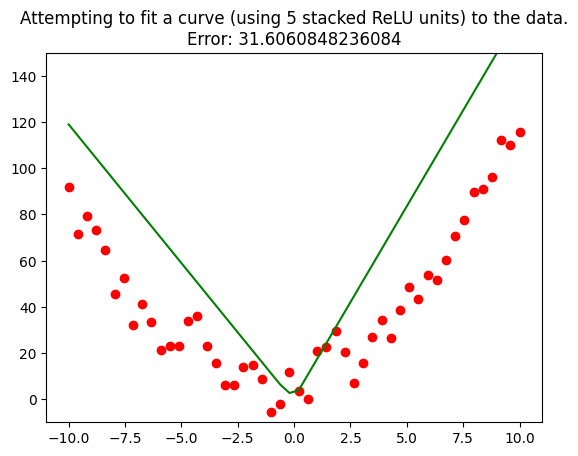

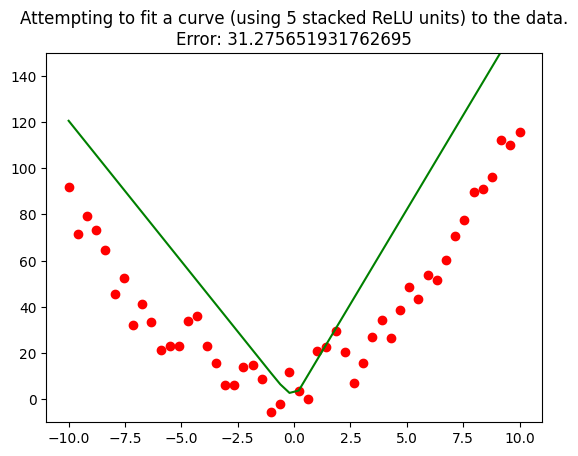

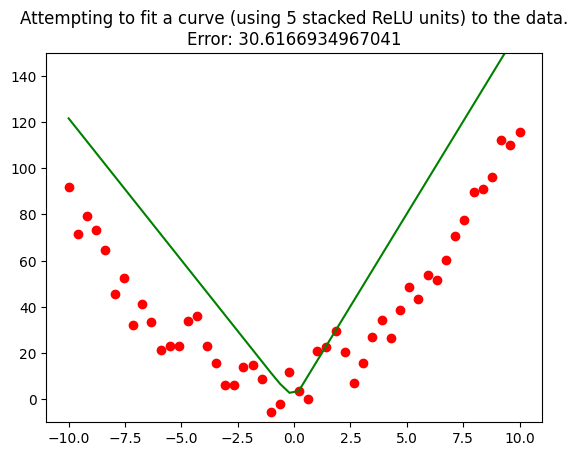

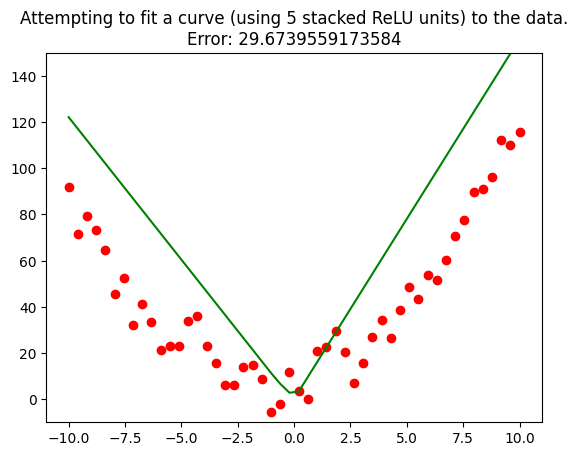

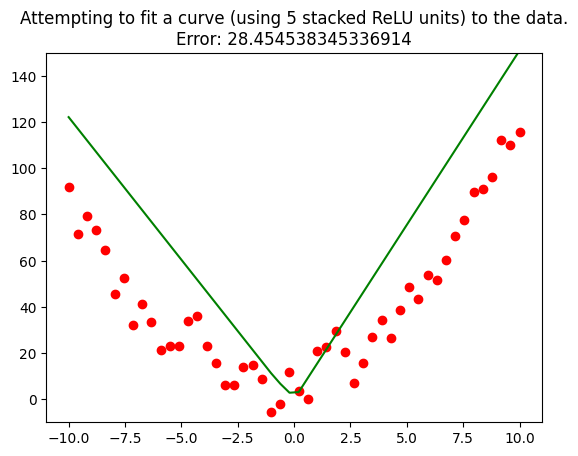

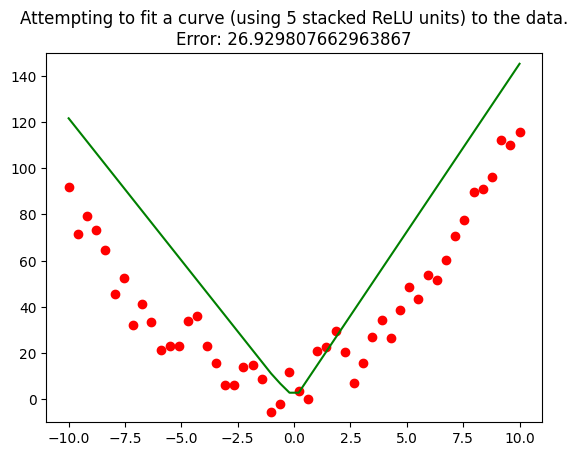

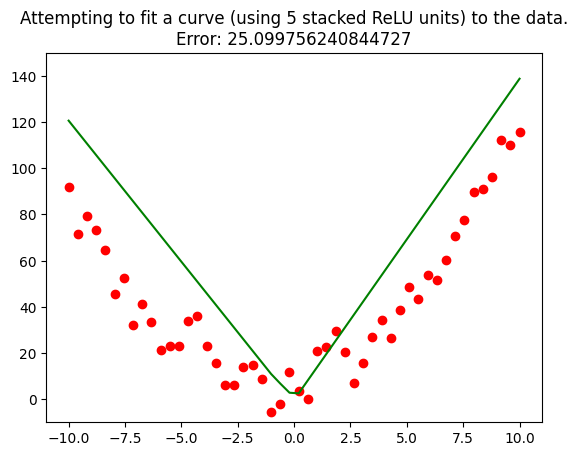

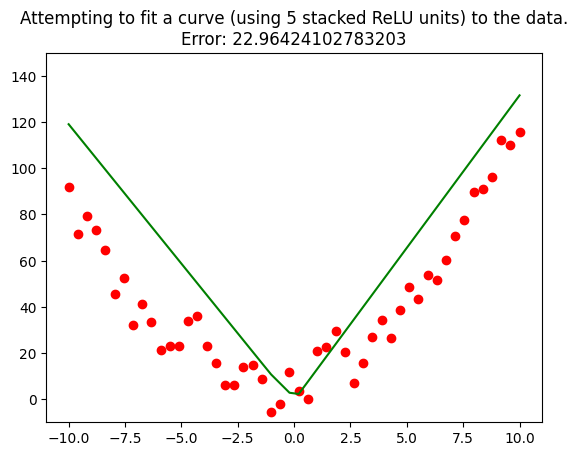

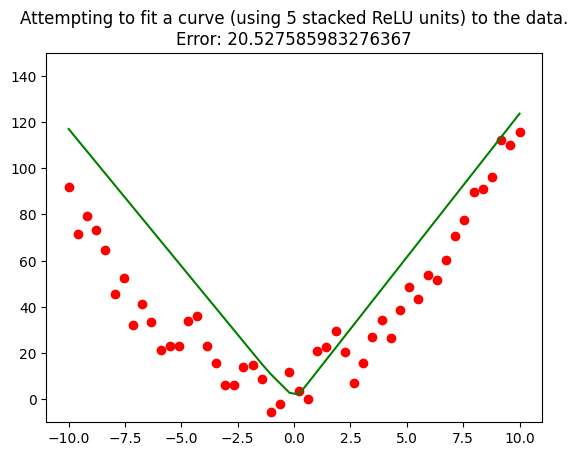

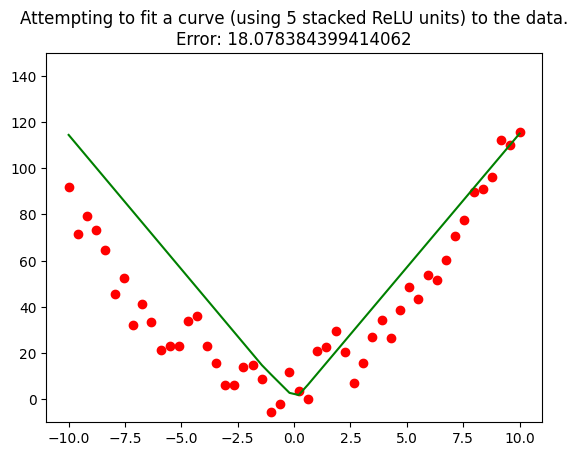

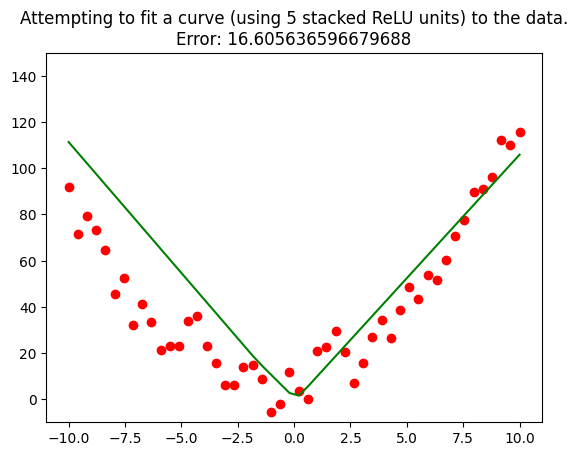

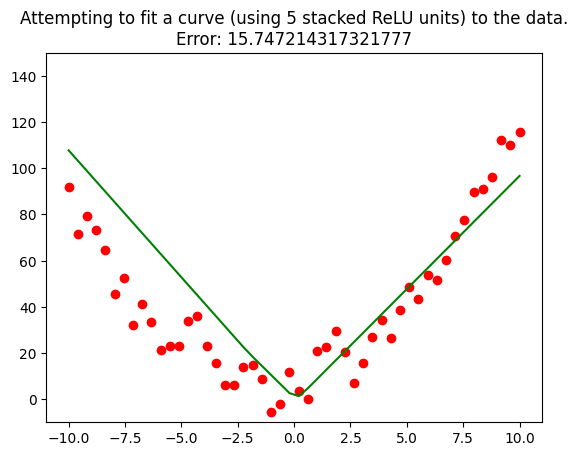

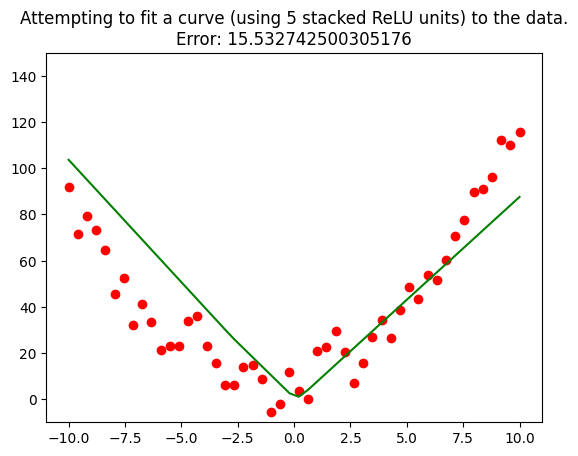

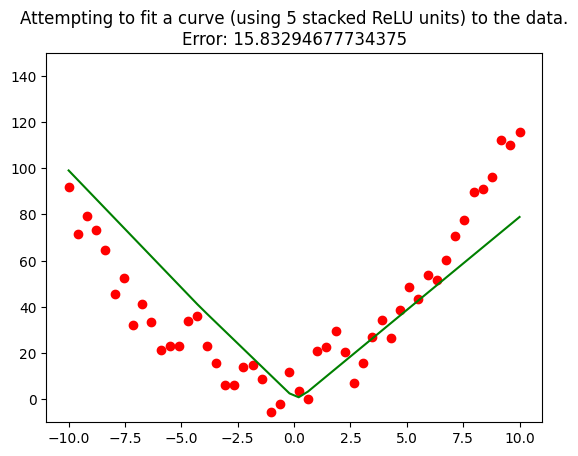

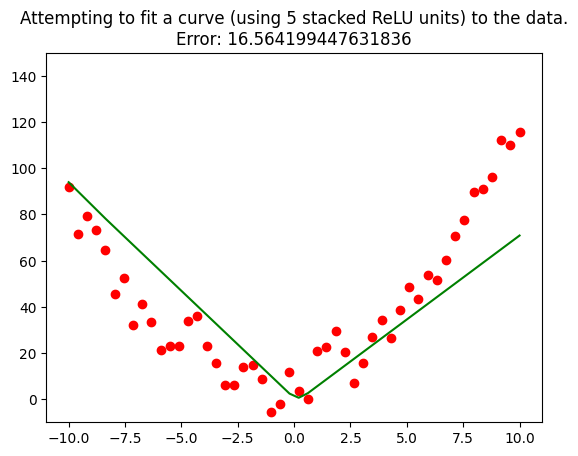

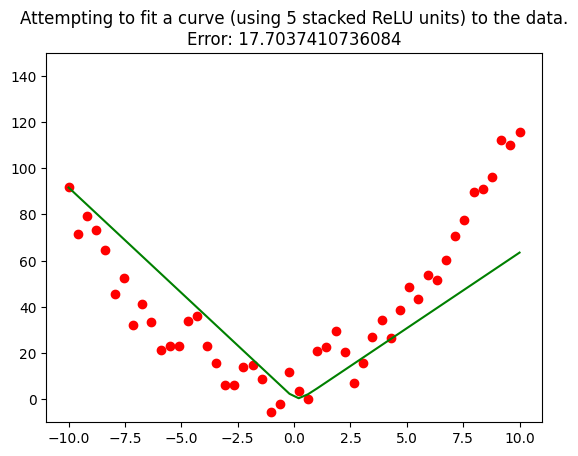

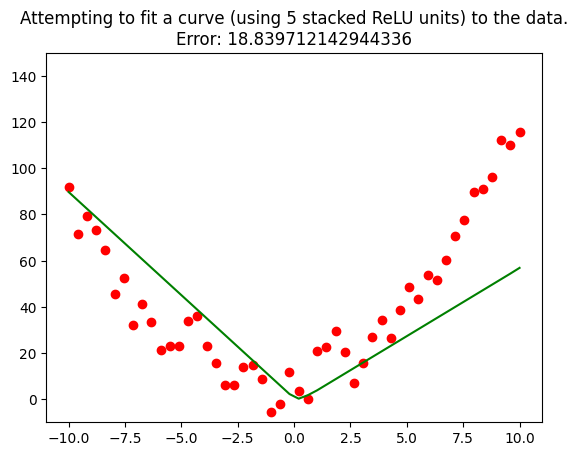

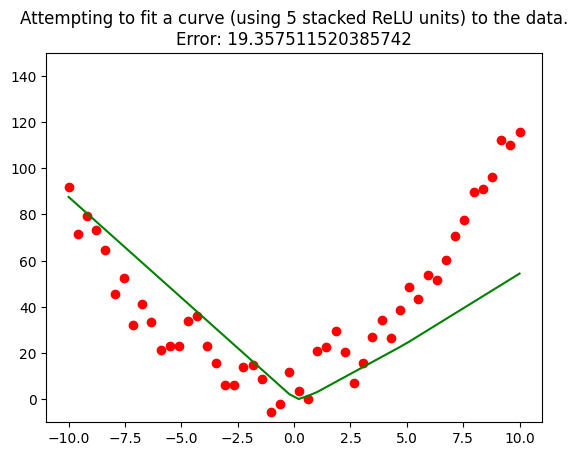

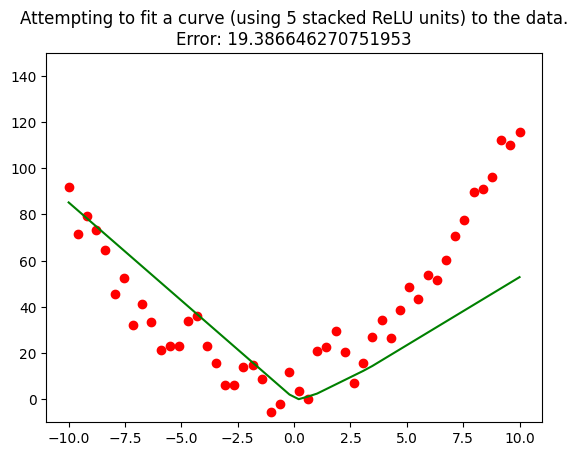

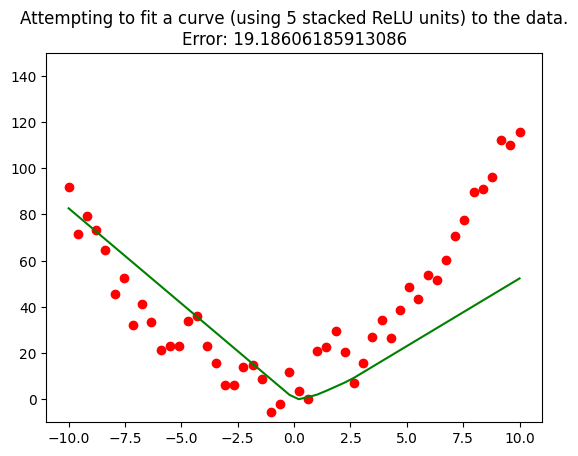

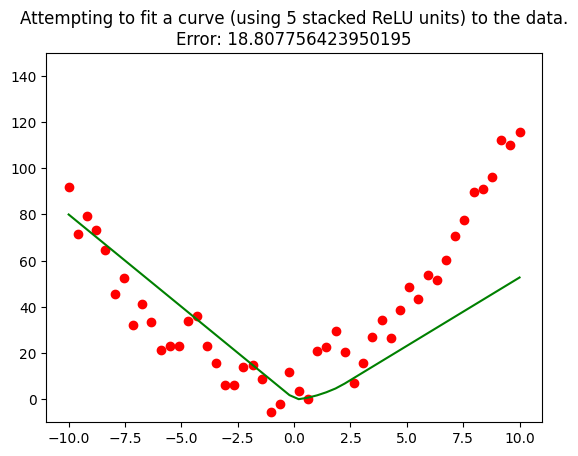

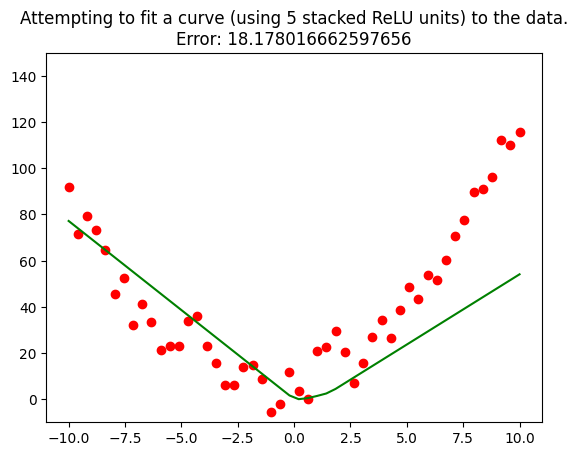

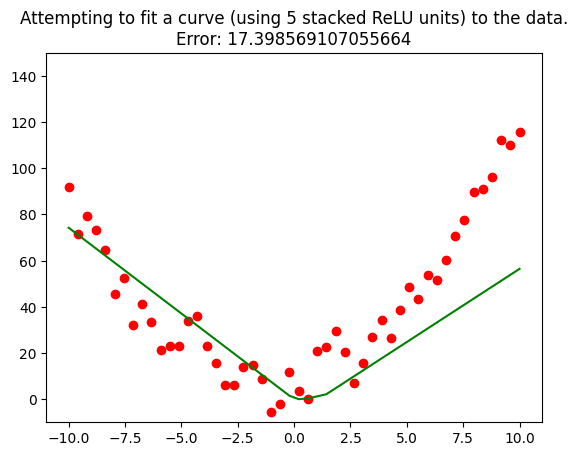

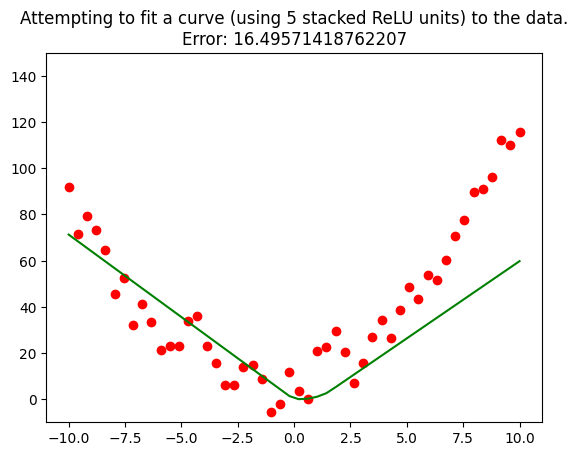

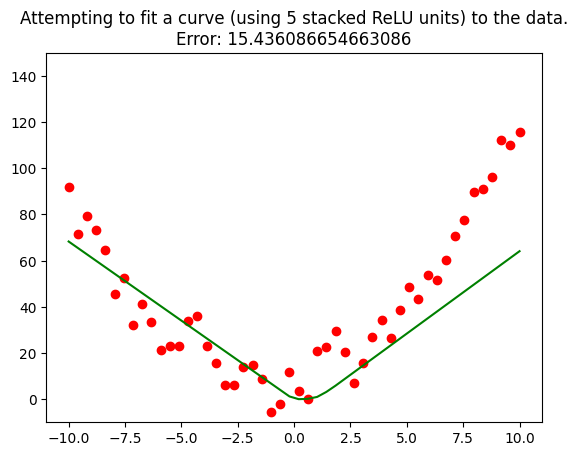

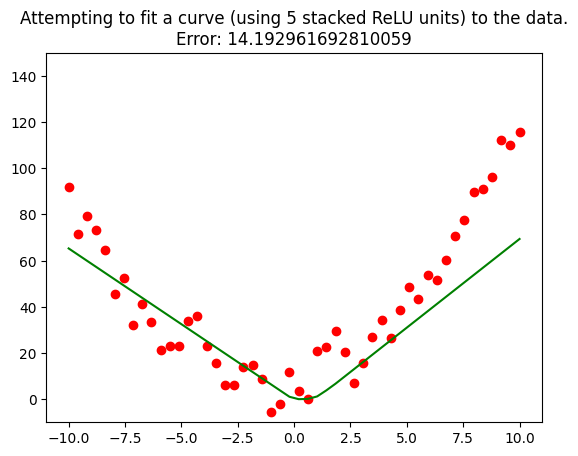

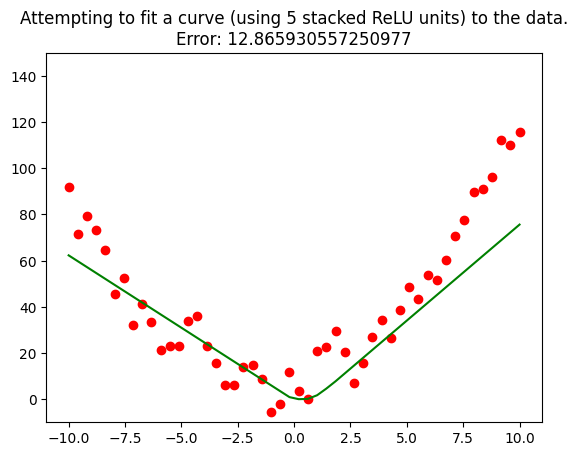

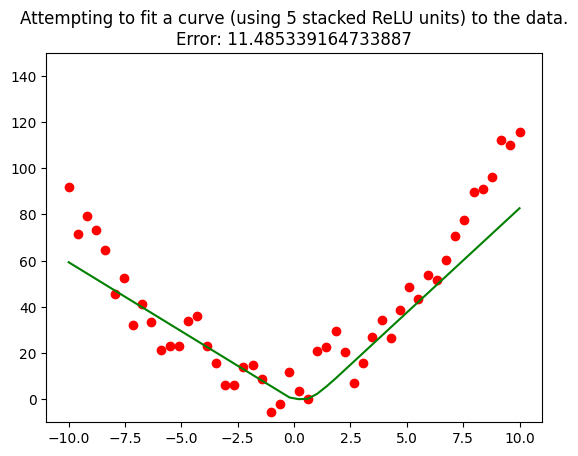

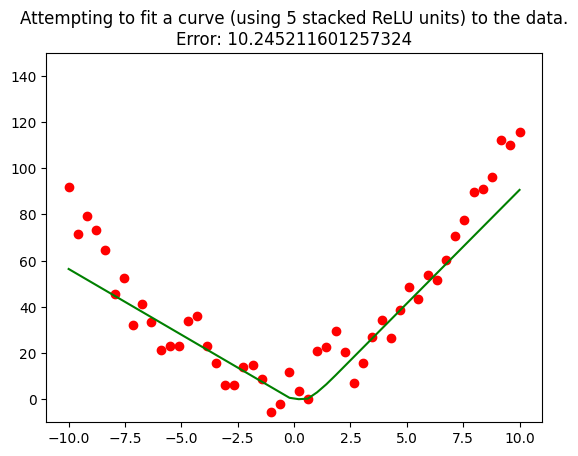

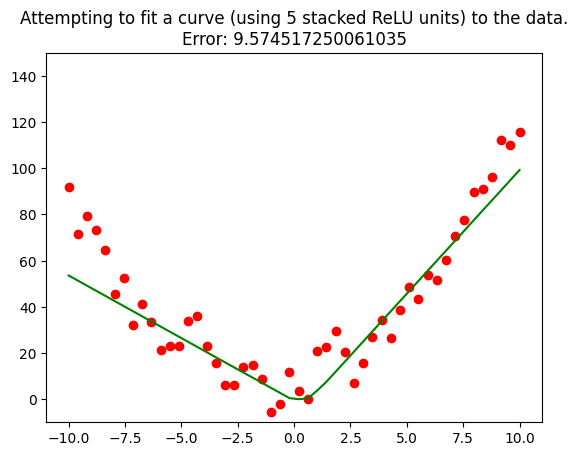

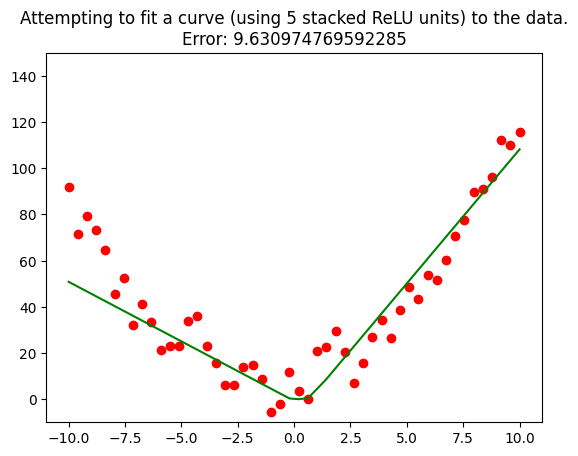

In [14]:
old_error = None
learning_rate = 0.01

for i in range(148):
    error = plot_relus_vs_noisy_Y(*parameters)
    
    error.backward()   
    
    with torch.no_grad():
        parameters -= (parameters.grad * learning_rate)
    plt.pause(0.0001)

**For one last time, let's view the final fit.**

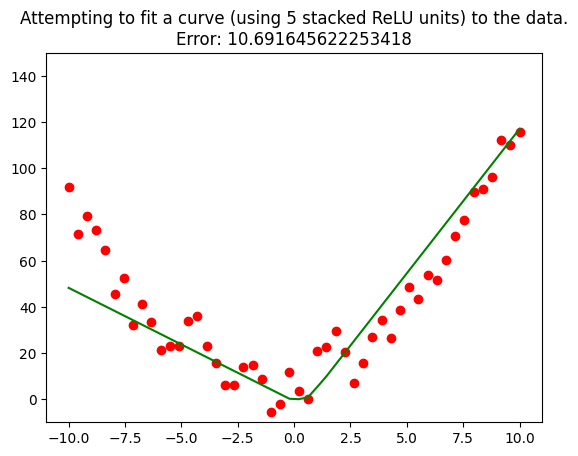

In [15]:
with torch.no_grad():
    plot_relus_vs_noisy_Y(*parameters)

# Thank You